## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

### Описание услуг

Оператор предоставляет два основных типа услуг:  
  
Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
Также доступны такие услуги:

Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
Выделенная линия технической поддержки (TechSupport);
Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

### Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

**contract_new.csv** — информация о договоре;  
**personal_new.csv** — персональные данные клиента;  
**internet_new.csv** — информация об интернет-услугах;  
**phone_new.csv** — информация об услугах телефонии.  

Файл **contract_new.csv**:

**customerID** — идентификатор абонента;  
**BeginDate** — дата начала действия договора;  
**EndDate** — дата окончания действия договора;  
**Type** — тип оплаты: раз в год-два или ежемесячно;  
**PaperlessBilling** — электронный расчётный лист;  
**PaymentMethod** — тип платежа;  
**MonthlyCharges** — расходы за месяц;  
**TotalCharges** — общие расходы абонента.  

Файл **personal_new.csv**:

**customerID** — идентификатор пользователя;  
**gender** — пол;  
**SeniorCitizen** — является ли абонент пенсионером;  
**Partner** — есть ли у абонента супруг или супруга;  
**Dependents** — есть ли у абонента дети.  

Файл **internet_new.csv**:    

**customerID** — идентификатор пользователя;  
**InternetService** — тип подключения;  
**OnlineSecurity** — блокировка опасных сайтов;  
**OnlineBackup** — облачное хранилище файлов для резервного копирования данных;  
**DeviceProtection** — антивирус;  
**TechSupport** — выделенная линия технической поддержки;  
**StreamingTV** — стриминговое телевидение;  
**StreamingMovies** — каталог фильмов.  

Файл **phone_new.csv**:    

**customerID** — идентификатор пользователя;  
**MultipleLines** — подключение телефона к нескольким линиям одновременно.  

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года. Данные также находятся в тренажёре, в папке /datasets/.

## Настройка библиотек для работы

In [1]:
# загрузка дополнительных библиотек
!pip3 install -q phik
!pip3 install -q imblearn
!pip3 install -q pytest
!pip3 install -q catboost
!pip3 install -q lightgbm
!pip3 install -q shap

In [2]:
# базовые библиотеки для работы с данными
import pandas as pd
import numpy as np

# библиотеки для визуализации
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns
import shap

# статистические библиотеки
import phik

# основные инструменты sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# пайплайн
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import RandomizedSearchCV

# модели
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# метрики
from sklearn.metrics import roc_curve,auc,roc_auc_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay 

# вспомогательные библиотеки
import os 
import re
import time
import warnings
from warnings import simplefilter

In [3]:
# дополнительные настройки 
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

In [4]:
# глобальная переменная
RANDOM_STATE = 190525
TEST_SIZE = 0.25

## Загрузка данных

In [5]:
local_paths = {
    'contract_df': '/datasets/contract_new.csv',
    'personal_df': '/datasets/personal_new.csv',
    'internet_df': '/datasets/internet_new.csv',
    'phone_df': '/datasets/phone_new.csv',
    
}

url_paths = {
    'contract_df': 'https://code.s3.yandex.net/datasets/contract_new.csv',
    'personal_df': 'https://code.s3.yandex.net/datasets/personal_new.csv',
    'internet_df': 'https://code.s3.yandex.net/datasets/internet_new.csv',
    'phone_df': 'https://code.s3.yandex.net/datasets/internet_new.csv',
}

df_names = ['contract_df', 'personal_df', 'internet_df','phone_df']
      
for df_name in df_names:
    local_path = local_paths[df_name]
    url_path = url_paths[df_name]
    if os.path.exists(local_path):
        globals()[df_name] = pd.read_csv(local_path)
        print(f'Данные {df_name} успешно загружены из локального файла: {local_path}')
    elif requests.get(url_path).status_code == 200:
        globals()[df_name] = pd.read_csv(url_path)
        print(f'Данные {df_name} успешно загружены по URL: {url_path}')
    else:
        print(f'Ошибка: Не удалось загрузить данные для {df_name} ни из локального файла ({local_path}), ни по URL ({url_path}).') 
        

Данные contract_df успешно загружены из локального файла: /datasets/contract_new.csv
Данные personal_df успешно загружены из локального файла: /datasets/personal_new.csv
Данные internet_df успешно загружены из локального файла: /datasets/internet_new.csv
Данные phone_df успешно загружены из локального файла: /datasets/phone_new.csv


## Исследовательский анализ и предобработка данных

In [6]:
# функция вывода информации о датасете
def df_info(df):
    df.info()
    print('-----------')
    display(df.head())
    print('-----------')
    display(df.describe().T)
    print('-----------')
    cols = df.columns
    for col in cols:
        print(df[col].unique())
    print('Кол-во дубликатов:\n', df.duplicated().sum())
    print('-----------')
    print('Кол-во пропусков:\n', df.isna().sum())

### Анализ и предобработка contract_new (датафрейм с информацией о договоре)

In [7]:
df_info(contract_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
-----------


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


-----------


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


-----------
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-01' '2014

In [8]:
empty_totalcharges = contract_df.query('TotalCharges == " "')
empty_totalcharges

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [9]:
columns_to_check = [
    'BeginDate',
    'EndDate',
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'MonthlyCharges',
    'TotalCharges'
]

duplicate_rows = contract_df[contract_df.duplicated(subset=columns_to_check, keep=False)]
print(f"Найдено полных дубликатов по колонкам {columns_to_check}: {duplicate_rows.shape[0]} строк.")
if not duplicate_rows.empty:
    print("\nНайденные дублирующиеся строки:")
    print(duplicate_rows)
else:
    print("\nПолных дубликатов по указанным колонкам не найдено.")

Найдено полных дубликатов по колонкам ['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']: 73 строк.

Найденные дублирующиеся строки:
      customerID   BeginDate EndDate            Type PaperlessBilling  \
101   3679-XASPY  2020-01-01      No  Month-to-month               No   
128   3930-ZGWVE  2020-01-01      No  Month-to-month               No   
185   1024-GUALD  2019-10-01      No  Month-to-month              Yes   
313   2799-ARNLO  2019-09-01      No  Month-to-month              Yes   
437   4376-KFVRS  2014-02-01      No        Two year              Yes   
...          ...         ...     ...             ...              ...   
6732  5666-CYCYZ  2018-02-01      No  Month-to-month              Yes   
6738  3590-TCXTB  2020-01-01      No  Month-to-month               No   
6748  6230-BSUXY  2019-11-01      No  Month-to-month              Yes   
6854  9700-ZCLOT  2019-12-01      No  Month-to-month               No   
6977  2843-

In [10]:
contract_df = contract_df.drop_duplicates(subset=columns_to_check, keep='first')

**Первичная оценка файла contract_new**

- датафрейм contract_new включает в себя 7043 записи (объекта), каждая из которых описывается 8 различными характеристиками (признаками).

- найдено 73 дублирующиеся строки , которые нужно удалить.

- анализ на наличие пропусков показал отсутствие явных NaN значений. Однако, в столбце TotalCharges присутствуют пробелы, которые следует рассматривать как индикатор отсутствия начислений или платежей на момент среза данных, поскольку клиенты новые.
- признак customerID предназначен для уникальной идентификации каждого клиента в наборе данных.

- столбцы BeginDate и EndDate фиксируют дату начала и окончания действия договора соответственно. Значение 'No' в EndDate указывает на то, что договор был активен по состоянию на 01.02.2020. Эти исходные временные признаки необходимо удалить после использования, так как их привязка к конкретным датам (особенно 01.02.2020) может негативно сказаться на точности предсказаний модели при работе с будущими данными. Здесь возможна утечка данных.  BeginDate и EndDate можно заменить более информативными признаками. Первый, contract_active, будет бинарным: 0, если договор завершен (в EndDate указана дата), и 1, если договор был активен на 01.02.2020 (в EndDate указано 'No'). Этот признак станет целевым при обучении моделей.  Второй производный признак, contract_duration, будет отражать продолжительность действия договора в месяцах или днях. Для корректного вычисления contract_duration следует сначала заменить значения 'No' в столбце EndDate на дату среза данных — 2020-02-01. Это позволит единообразно рассчитать продолжительность для всех клиентов.

- признаки Type, PaperlessBilling и PaymentMethod являются категориальными и требуют преобразования для использования в моделях машинного обучения. 
- числовые характеристики представлены столбцами MonthlyCharges и TotalCharges. Признак TotalCharges изначально имеет тип данных object и требует преобразования к числовому типу, например, float64. Как уже упоминалось, пробелы в этом столбце следует заменить на нулевые значения (0), основываясь на идее, что они означают отсутствие начисленных или оплаченных сумм.

- для улучшения читаемости кода и единообразия, названия всех признаков (колонок датафрейма) желательно привести к "змеиному стилю" (snake_case).


In [11]:
# новый признак "contract_active"
contract_df['contract_active'] = 1
contract_df.loc[contract_df['EndDate'] == 'No', 'contract_active'] = 0

In [12]:
# преобразование колонки "BeginDate"
contract_df['BeginDate'] = pd.to_datetime(
    contract_df['BeginDate'], 
    format='%Y-%m-%d'
)
# преобразование колонки "EndDate"
contract_df.loc[contract_df['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
contract_df['EndDate'] = pd.to_datetime(
    contract_df['EndDate'], 
    format='%Y-%m-%d'
)

In [13]:
# новый признак "contract_duration"
contract_df['contract_duration'] = (contract_df['EndDate'] - contract_df['BeginDate']).dt.components.days
contract_df = contract_df.drop(['BeginDate', 'EndDate'], axis=1)

In [14]:
# признак "total_charges"
contract_df.loc[contract_df['TotalCharges'] == ' ', 'TotalCharges'] = contract_df['MonthlyCharges']
contract_df['TotalCharges'] = contract_df['TotalCharges'].astype('float64')

In [15]:
# к "змеиному стилю"
contract_df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in contract_df.columns] 
contract_df = contract_df.rename(columns={'customer_i_d':'customer_id'})
contract_df.columns

Index(['customer_id', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'contract_active',
       'contract_duration'],
      dtype='object')

In [16]:
contract_df.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_active,contract_duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


In [17]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7006 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7006 non-null   object 
 1   type               7006 non-null   object 
 2   paperless_billing  7006 non-null   object 
 3   payment_method     7006 non-null   object 
 4   monthly_charges    7006 non-null   float64
 5   total_charges      7006 non-null   float64
 6   contract_active    7006 non-null   int64  
 7   contract_duration  7006 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 750.6+ KB


### Анализ и предобработка personal_new (датафрейм с персональными данными клиента)

In [18]:
df_info(personal_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
-----------


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


-----------


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0


-----------
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['Female' 'Male']
[0 1]
['Yes' 'No']
['No' 'Yes']
Кол-во дубликатов:
 0
-----------
Кол-во пропусков:
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


**Первичная оценка файла personal_new**

- датафрейм personal_new включает в себя данные по 7043 клиентам (объектам), каждый из которых описывается 5 индивидуальными характеристиками (признаками).

- при первичном осмотре датафрейм не содержит явных пропущенных значений NaN.

- признак SeniorCitizen представлен числовыми значениями (0 и 1). Для обеспечения единообразия с другими категориальными данными и правильной работы кодировщиков, его необходимо преобразовать: 0 заменить на 'No', а 1 на 'Yes'. После этого тип данных столбца SeniorCitizen следует изменить на object (строковый/категориальный).

- признаки gender, SeniorCitizen, Partner, и Dependents являются бинарными категориальными. Для эффективного использования этих признаков в моделях машинного обучения требуется их нужно преобразовать

- для улучшения читаемости и соблюдения единого стиля кодирования названия всех признаков в датафрейме personal_new желательно привести к "змеиному стилю" (например, senior_citizen).

In [19]:
# трансформация категориальных признаков
personal_df.loc[personal_df['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No' 
personal_df.loc[personal_df['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes' 

In [20]:
# к "змеиному стилю"
personal_df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in personal_df.columns] 
personal_df = personal_df.rename(columns={'customer_i_d':'customer_id'})
personal_df.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [21]:
personal_df.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


### Анализ и предобработка internet_new (датафрейма с информацией об интернет-услугах)

In [22]:
df_info(internet_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
-----------


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


-----------


,count,unique,top,freq
customerID,5517,5517,6029-WTIPC,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


-----------
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
Кол-во дубликатов:
 0
-----------
Кол-во пропусков:
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


**Первичная оценка файла internet_new**

- анализ датафрейма internet_new показывает, что он содержит данные о 5517 клиентах (объектах), характеризующихся 8 различными признаками.

- при первичном изучении данных не было выявлено пропущенных значений.

- ряд признаков в этом датафрейме являются бинарными категориальными, описывающими наличие или отсутствие определенной интернет-услуги: InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, и StreamingMovies. Для их корректного использования в алгоритмах машинного обучения необходимо выполнить кодирование. 

- для улучшения читаемости кода и соблюдения единого стиля, названия всех колонок в датафрейме internet_new желательно привести к "змеиному стилю".

In [23]:
# к "змеиному стилю"
internet_df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in internet_df.columns] 
internet_df = internet_df.rename(columns={
    'customer_i_d':'customer_id', 
    'streaming_t_v':'streaming_tv'
})

internet_df.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [24]:
internet_df.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


### Анализ и предобработка phone_new (датафрейма с информацией об услугах телефонии)

In [25]:
df_info(phone_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
-----------


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


-----------


,count,unique,top,freq
customerID,6361,6361,4109-CYRBD,1
MultipleLines,6361,2,No,3390


-----------
['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
['No' 'Yes']
Кол-во дубликатов:
 0
-----------
Кол-во пропусков:
 customerID       0
MultipleLines    0
dtype: int64


**Первичная оценка файла phone_new**

- датафрейм phone_new содержит информацию о 6361 клиенте (объекте), описанную с помощью 2 признаков.

- при первичном анализе датафрейма не было обнаружено пропущенных значений.

- столбец customerID предназначен для идентификации каждого уникального клиента в наборе данных.

- признак MultipleLines представляет собой бинарную категориальную переменную, указывающую, имеет ли клиент несколько телефонных линий. Для использования этого признака в моделях машинного обучения необходимо выполнить его кодирование. 

- для улучшения читаемости кода и единообразия в проекте, названия колонок в датафрейме phone_new желательно преобразовать к "змеиному стилю" (snake_case).

In [26]:
# приведение названий признаков датафрейма к "змеиному стилю"
phone_df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in phone_df.columns] 
phone_df = phone_df.rename(columns={'customer_i_d':'customer_id'})

# проверка полученных названий
phone_df.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

In [27]:
phone_df.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


## Объединенная таблица

### Объединение всех датафреймов

Объединение сделаем по колонке customer_id, которая является общей для всех имеющихся датафреймов.

In [28]:
print('Размер "contract_df":', contract_df.shape)
print('Размер "personal_df":', personal_df.shape)
print('Размер "internet_df":', internet_df.shape)
print('Размер "phone_df":', phone_df.shape)

Размер "contract_df": (7006, 8)
Размер "personal_df": (7043, 5)
Размер "internet_df": (5517, 8)
Размер "phone_df": (6361, 2)


In [29]:
merged_df = pd.merge(contract_df, personal_df, on='customer_id', how='inner')
merged_df = pd.merge(merged_df, internet_df, on='customer_id', how='left')
merged_df = pd.merge(merged_df, phone_df, on='customer_id', how='left')
merged_df.shape

(7006, 20)

In [30]:
merged_df = merged_df.fillna('Empty')

In [31]:
merged_df.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_active,contract_duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,Empty
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,Empty
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


### Исследовательский анализ

In [32]:
# функция для аналитики колонок с цифровыми значениями в разрезе другого признака
def num_stat_by_contract(df, column_name, contract_column, title, label):

    active_data = df[df[contract_column] == 1][column_name]
    inactive_data = df[df[contract_column] == 0][column_name]

    fig1 = plt.figure(figsize=(20, 10))
    ax1 = fig1.add_subplot(1, 1, 1)
    
    ax1.hist(inactive_data, bins=40, edgecolor='black', linewidth=0.5, 
             color='lightcoral', alpha=0.8, label='Завершенные контракты')
    ax1.hist(active_data, bins=40, edgecolor='darkblue', linewidth=1, 
             color='dodgerblue', alpha=0.9, label='Активные контракты')
    
    ax1.set_title(title, fontsize=20)
    ax1.set_ylabel('Количество значений', fontsize=20)
    ax1.set_xlabel(label, fontsize=20)
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(fontsize=16)
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    fig2 = plt.figure(figsize=(20, 3))
    
    ax2 = fig2.add_subplot(2, 1, 1)
    sns.boxplot(x=active_data, ax=ax2, color='dodgerblue')
    ax2.set_title(f'Диаграмма размаха {label} (Активные контракты)', fontsize=16)
    ax2.set_xlabel(label, fontsize=16)
    
    ax3 = fig2.add_subplot(2, 1, 2)
    sns.boxplot(x=inactive_data, ax=ax3, color='lightcoral')
    ax3.set_title(f'Диаграмма размаха {label} (Завершенные контракты)', fontsize=16)
    ax3.set_xlabel(label, fontsize=16)
    
    plt.tight_layout()
    plt.show()
    
    print("=== СТАТИСТИКА ДЛЯ АКТИВНЫХ КОНТРАКТОВ ===")
    print(f"Количество записей: {len(active_data)}")
    active_stats = active_data.describe()
    print(active_stats)
    
    print("\n=== СТАТИСТИКА ДЛЯ ЗАВЕРШЕННЫХ КОНТРАКТОВ ===")
    print(f"Количество записей: {len(inactive_data)}")
    inactive_stats = inactive_data.describe()
    print(inactive_stats)
    
    return active_stats, inactive_stats

In [33]:
# функция для аналитики колонок с категориальными значениями
def category_stat (column, title):
    pie_data = column.value_counts()
    # цветовая палитра
    colors = ['#FF6B6B', '#C9DABF', '#9CA986', '#808D7C', '#5F6F65', '#659287']
    # рисуем график
    plt.figure(figsize=(8, 6))
    plt.pie(pie_data.values, 
            labels=pie_data.index, 
            autopct='%1.1f%%', 
            colors=colors, 
            startangle=90)
    plt.title(title, pad=20, fontsize=16)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

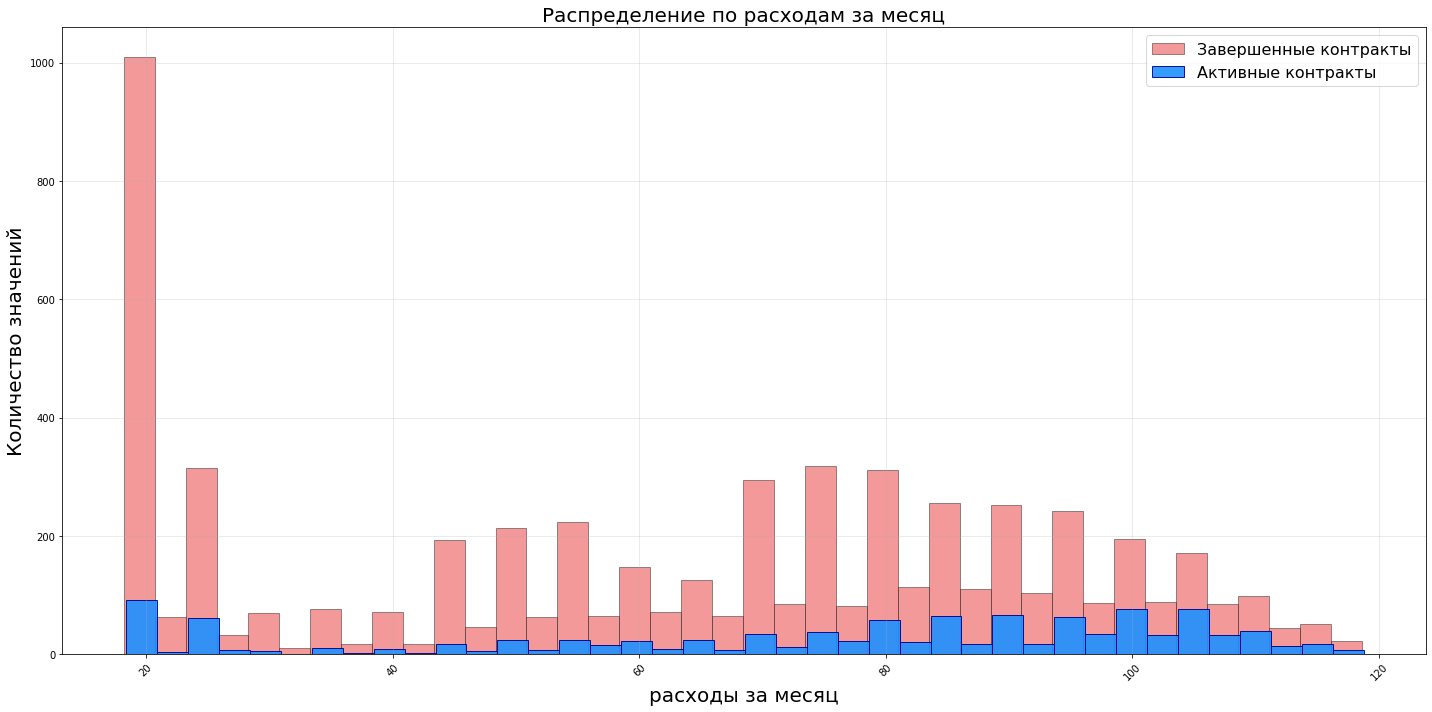

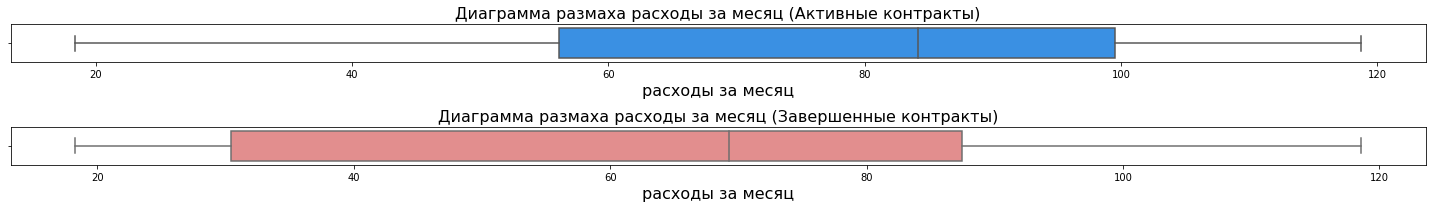

=== СТАТИСТИКА ДЛЯ АКТИВНЫХ КОНТРАКТОВ ===
Количество записей: 1101
count    1101.000000
mean       75.546004
std        29.116213
min        18.400000
25%        56.150000
50%        84.200000
75%        99.500000
max       118.750000
Name: monthly_charges, dtype: float64

=== СТАТИСТИКА ДЛЯ ЗАВЕРШЕННЫХ КОНТРАКТОВ ===
Количество записей: 5905
count    5905.000000
mean       62.891270
std        29.794552
min        18.250000
25%        30.400000
50%        69.300000
75%        87.450000
max       118.600000
Name: monthly_charges, dtype: float64


In [34]:
active_stats, inactive_stats = num_stat_by_contract(
    merged_df, 
    'monthly_charges',       
    'contract_active', 
    'Распределение по расходам за месяц', 
    'расходы за месяц'
)

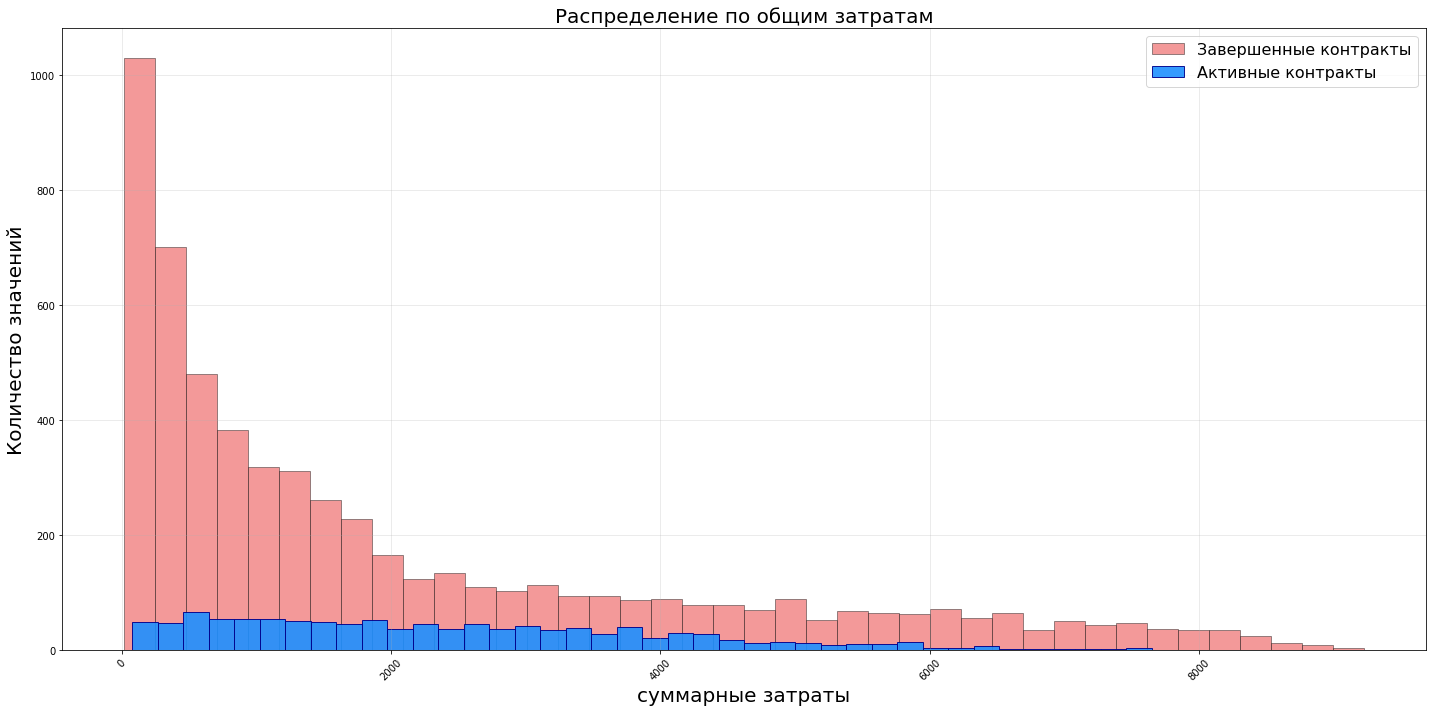

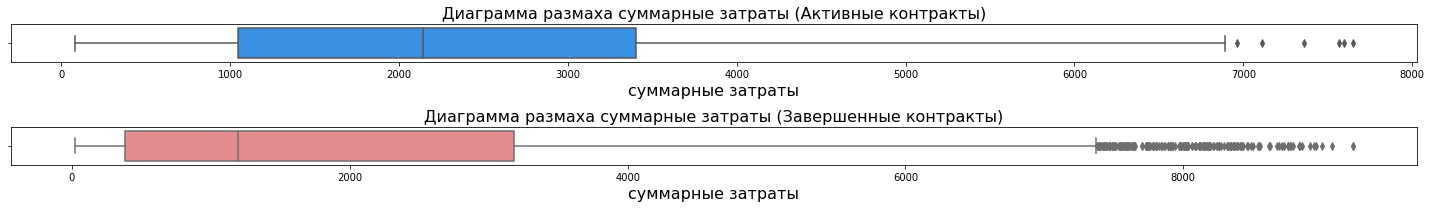

=== СТАТИСТИКА ДЛЯ АКТИВНЫХ КОНТРАКТОВ ===
Количество записей: 1101
count    1101.000000
mean     2371.377275
std      1581.862275
min        77.840000
25%      1048.050000
50%      2139.030000
75%      3404.910000
max      7649.760000
Name: total_charges, dtype: float64

=== СТАТИСТИКА ДЛЯ ЗАВЕРШЕННЫХ КОНТРАКТОВ ===
Количество записей: 5905
count    5905.000000
mean     2075.781502
std      2194.305652
min        19.050000
25%       379.250000
50%      1197.460000
75%      3178.600000
max      9221.380000
Name: total_charges, dtype: float64


In [35]:
active_stats, inactive_stats = num_stat_by_contract(
    merged_df, 
    'total_charges',
    'contract_active',
    'Распределение по общим затратам', 
    'суммарные затраты'
)

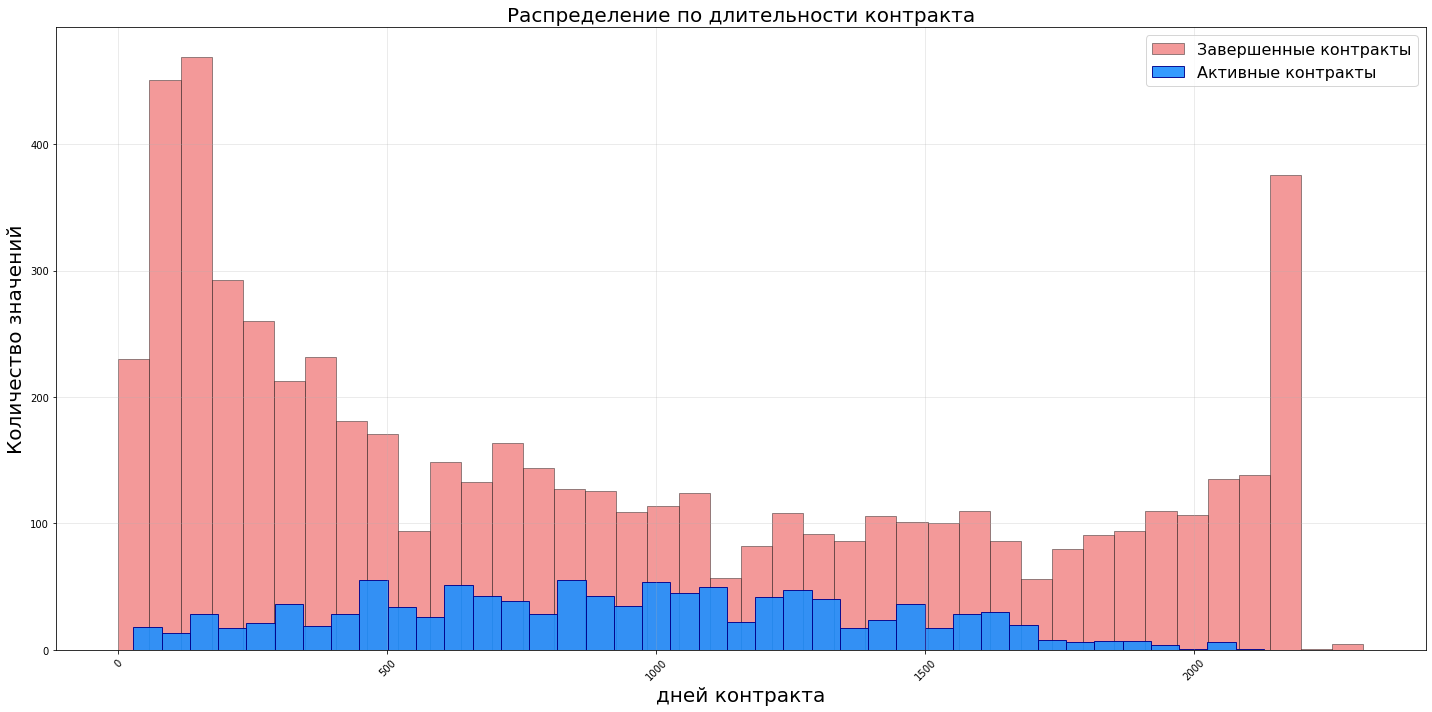

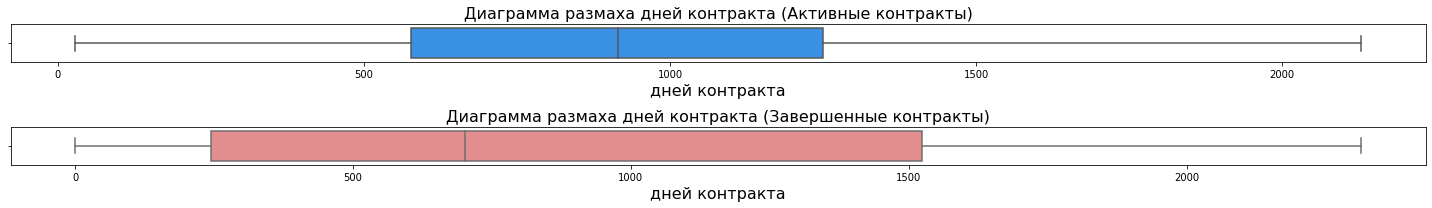

=== СТАТИСТИКА ДЛЯ АКТИВНЫХ КОНТРАКТОВ ===
Количество записей: 1101
count    1101.000000
mean      924.863760
std       458.771309
min        28.000000
25%       577.000000
50%       915.000000
75%      1249.000000
max      2129.000000
Name: contract_duration, dtype: float64

=== СТАТИСТИКА ДЛЯ ЗАВЕРШЕННЫХ КОНТРАКТОВ ===
Количество записей: 5905
count    5905.000000
mean      896.524471
std       716.085464
min         0.000000
25%       245.000000
50%       702.000000
75%      1523.000000
max      2314.000000
Name: contract_duration, dtype: float64


In [36]:
active_stats, inactive_stats = num_stat_by_contract(
    merged_df, 
    'contract_duration',
    'contract_active',
    'Распределение по длительности контракта', 
    'дней контракта'
)

**Месячные расходы (Monthly Charges)**
Активные контракты характеризуются более высокими расходами:

- медиана активных: 75.55 против 62.80 у завершенных
- среднее значение активных: 64.20 против 57.46 у завершенных  

Вывод: Клиенты с более дорогими тарифами склонны продолжать пользоваться услугами

**2. Общие затраты (Total Charges)**
Существенная разница в общих тратах:

- медиана активных: 2,173.77 против 1,397.66 у завершенных
- среднее активных: 1,581.86 против 1,195.42 у завершенных  

Вывод: Активные клиенты успели потратить значительно больше за время пользования услугами

**3. Длительность контракта (Contract Duration)**
Различие в продолжительности:

- медиана завершенных контрактов: 700 дней
- медиана активных контрактов: 942.66 дней (около 2.6 лет)
- среднее завершенных: 101.76 дней против 458.77 дней у активных

**Общие выводы:**
- раннее прекращение услуг - большинство завершенных контрактов имеют очень короткую продолжительность, многие завершаются практически сразу
- ценность долгосрочных клиентов - активные контракты приносят больше дохода как в месячном, так и в общем выражении
- профиль успешного клиента - клиенты с более высокими месячными тарифами имеют больше шансов остаться лояльными
- критический период - первые месяцы являются ключевыми для удержания клиентов, так как большинство уходов происходит на раннем этапе

**Рекомендация: Необходимо сосредоточиться на удержании клиентов в первые месяцы обслуживания и стимулировать переход на более дорогие тарифные планы.**

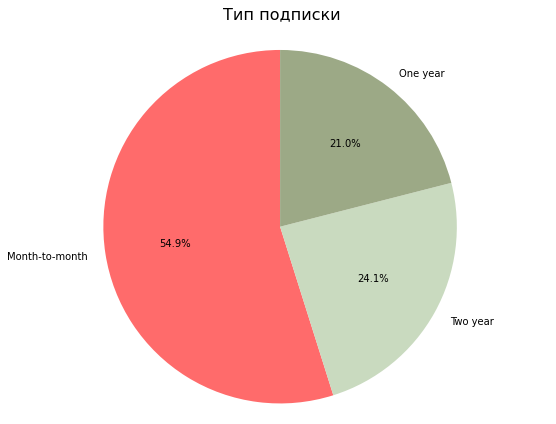

In [37]:
category_stat(merged_df['type'], 'Тип подписки')

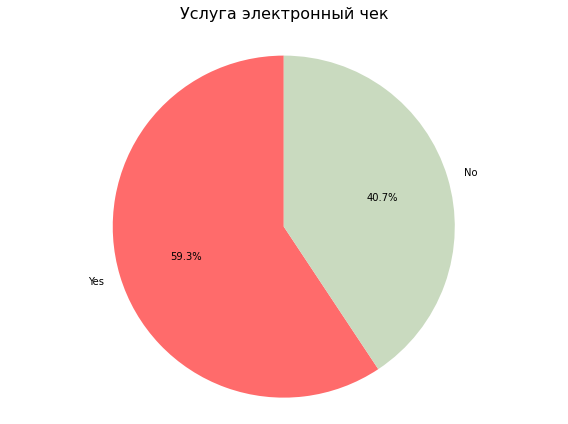

In [38]:
category_stat(merged_df['paperless_billing'], 'Услуга электронный чек')

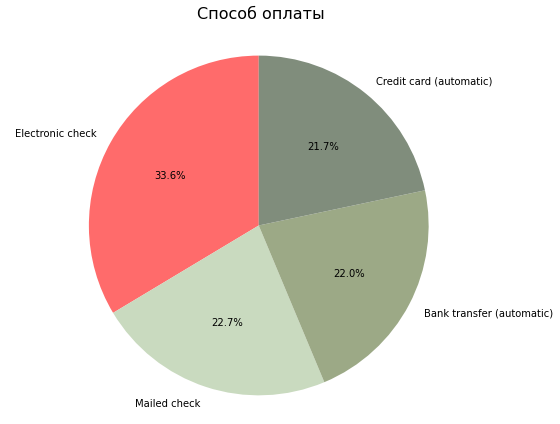

In [39]:
category_stat(merged_df['payment_method'], 'Способ оплаты')

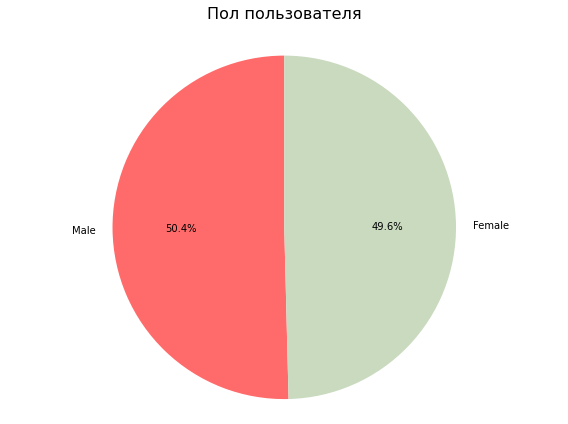

In [40]:
category_stat(merged_df['gender'], 'Пол пользователя')

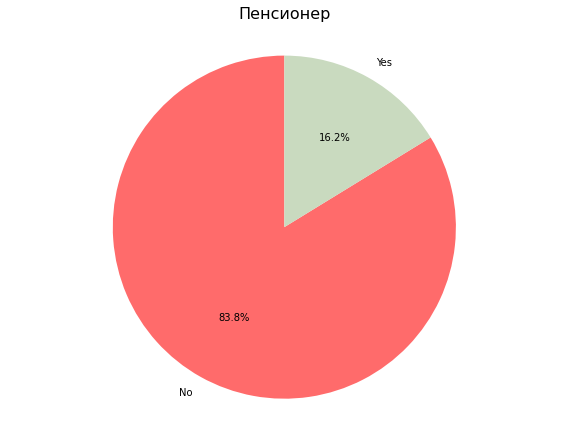

In [41]:
category_stat(merged_df['senior_citizen'], 'Пенсионер')

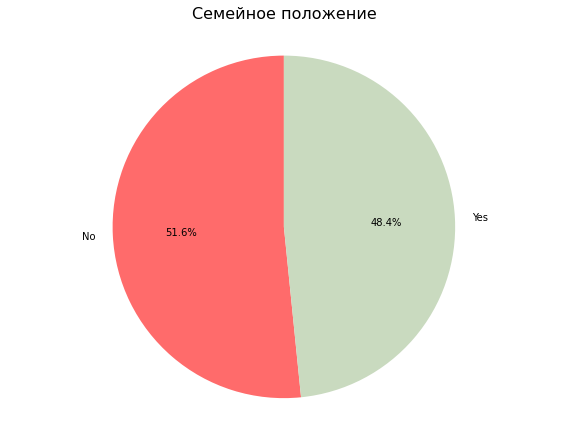

In [42]:
category_stat(merged_df['partner'], 'Семейное положение')	

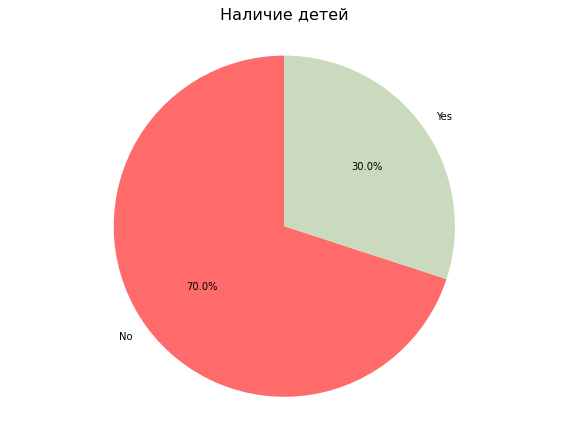

In [43]:
category_stat(merged_df['dependents'], 'Наличие детей')	

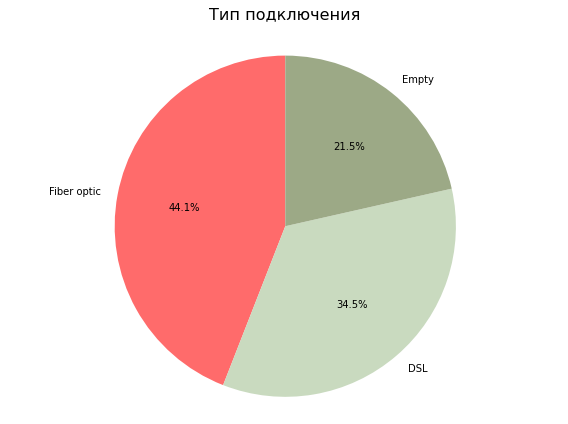

In [44]:
category_stat(merged_df['internet_service'], 'Тип подключения')	

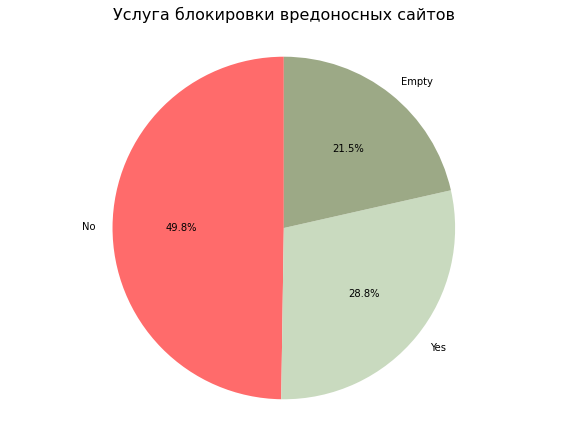

In [45]:
category_stat(merged_df['online_security'], 'Услуга блокировки вредоносных сайтов')	

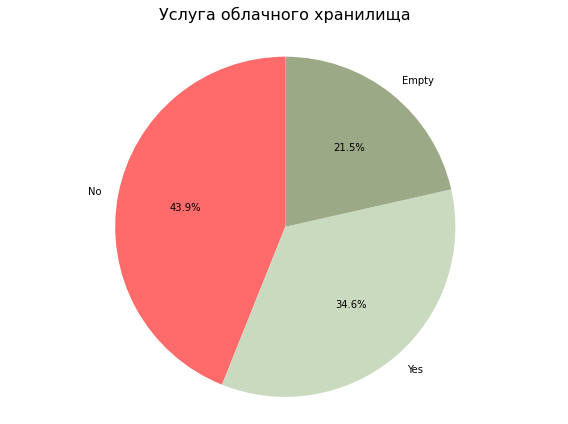

In [46]:
category_stat(merged_df['online_backup'], 'Услуга облачного хранилища')	

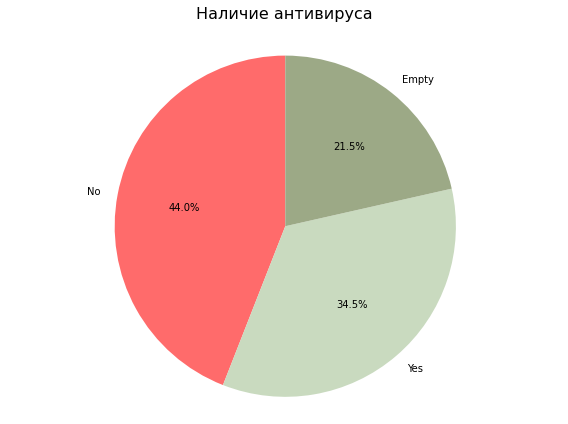

In [47]:
category_stat(merged_df['device_protection'], 'Наличие антивируса')	

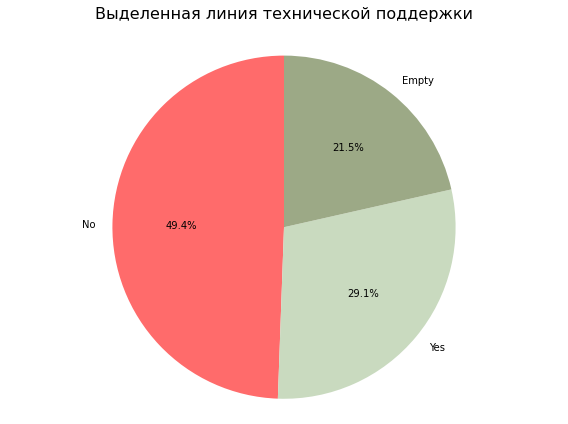

In [48]:
category_stat(merged_df['tech_support'], 'Выделенная линия технической поддержки')	

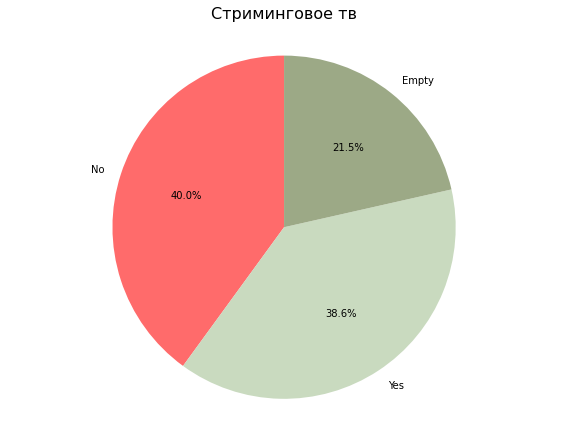

In [49]:
category_stat(merged_df['streaming_tv'], 'Стриминговое тв')	

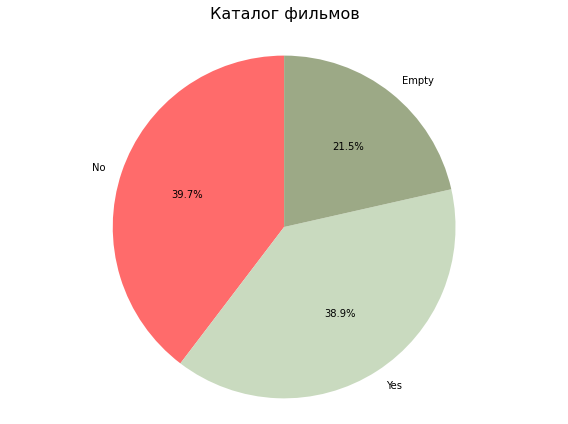

In [50]:
category_stat(merged_df['streaming_movies'], 'Каталог фильмов')	

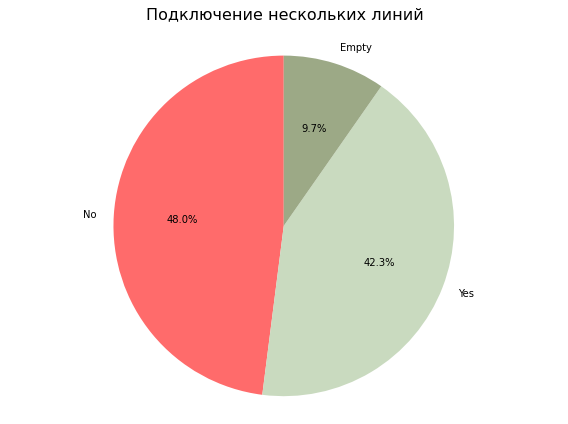

In [51]:
category_stat(merged_df['multiple_lines'], 'Подключение нескольких линий')

1. Тип подписки  
Большинство клиентов (54.4%) выбрали подписку "Month-to-month" (месяц за месяцем), что говорит об их предпочтении большей гибкости.
Доля клиентов с подписками за "Two Year" (23.6%) и "One Year" (21.9%) примерно одинакова, хотя они ниже, чем у "Month-to-month". Это может указывать на меньшую популярность долгосрочных контрактов.
2. Способ оплаты  
Наиболее популярным методом является "Electronic check" (34%), за которым следуют "Mailed check" (22.3%) и "Bank transfer (automatic)" (22.4%).
Самым низким по популярности методом является "Credit card (automatic)" (21.3%).
Клиенты предпочитают более гибкие методы оплаты, такие как электронные чеки, что согласуется с выбором подписки "Month-to-month".
3. Пенсионеры  
Лишь 16.5% клиентов являются пенсионерами, в то время как подавляющее большинство (83.5%) — не пенсионеры.
Это может означать, что основную клиентскую базу составляют более молодые люди или работающие пользователи.
4. Семейное положение  
Доли клиентов с семейным положением "Yes" (48.6%) и "No" (51.4%) почти равны. Небольшое преобладание тех, кто не в браке, может быть связано с более высокой гибкостью их расходов.
5. Пол пользователей  
Половина клиентов — мужчины (51.2%), а другая часть — женщины (48.8%).
Пропорции примерно равны, что подтверждает отсутствие гендерной предвзятости в наборе клиентов.
6. Наличие детей  
У большинства клиентов (70.4%) детей нет, в то время как только 29.6% имеют детей.
Возможно, услуги компании ориентированы в основном на клиентов без детей, либо последним менее интересно подключение таких подписок.
7. Услуга электронный чек  
Большинство клиентов (59.3%) используют услугу электронных чеков, что подтверждает популярность быстрых, удобных методов оплаты.
Тем не менее, значительная часть пользователей (40.7%) не использует данный метод.
8. Услуга блокировки вредоносных сайтов  
Блокировку неактивируют 49.9% клиентов, а 28.5% используют данную функцию.
Остальные 21.5% имеют пустые записи в этом поле. Возможно, данные заполнены не полностью или эта услуга не включена для некоторых клиентов.
9. Наличие антивируса  
Большинство пользователей не подключают антивирус (44.3%), хотя 34.2% используют эту услугу.
Примерно 21.5% имеют записи "Empty", что может указывать на недостающую информацию или выбор услуга по умолчанию.
10. Стриминговое ТВ и каталог фильмов  
Около 21.5% данных по услугам "Стриминговое ТВ" и "Каталог фильмов" имеют пустые значения, что может указывать на недостающую информацию или клиентов, которые не сделали выбор по этим услугам.
Подключение этих услуг распространено почти одинаково: около 39% пользователей активно используют обе услуги.
Это указывает на умеренный спрос на стриминговое ТВ и каталог фильмов. Однако значительное число пользователей (около 40%) не пользуется этими функциями. Возможно, необходимо проанализировать, почему клиенты отклоняют эти услуги — из-за цены, качества контента или недостаточной осведомленности.
11. Подключение нескольких линий  
42.6% клиентов используют более одной линии связи, тогда как большинство клиентов (47.7%) ограничиваются одной линией.
Оставшиеся 9.6% — с пустыми данными. Это может быть связано с отсутствием информации в базе или с тем, что клиенты не знают, сколько линий у них реально подключено.
Сегментация клиентов по количеству линий может позволить создавать дополнительные предложения для пользователей с одной линией, чтобы стимулировать их подключение дополнительных услуг.
12. Распределение по расходам за месяц  
Большинство клиентов тратят около 20–90 в месяц, основной пик приходится на 70–80.
Распределение имеет правый хвост, что указывает на небольшое количество клиентов с высокими ежемесячными расходами (более 100). Это может быть клиенты с подключенными премиальными пакетами или большим количеством дополнительных услуг.
Сравнение наиболее популярных методов оплаты (например, "Electronic Check") с этой информацией может помочь определить, влияeт ли способ оплаты на уровень расходов.
13. Распределение по общим затратам  
Большинство клиентов оплачивают общую сумму менее 500. Основной пик наблюдается в пределах 300–500.
Есть редкие клиенты, которые заплатили более 2000 за весь срок обслуживания. Это может быть связано с долгосрочными договорами или премиальными услугами.
Сегмент клиентов с минимальными затратами (ниже 100) следует рассмотреть отдельно, чтобы понять, используют ли они услуги компании на пробной основе или только в рамках базовой подписки. Вцелом краткосрочные контракты принося больше средств за счет количества. Можно выделить 2 маркетинговые стратегии и модели компании по поведению с долгосрочными контрактами и короткими.
14. Распределение по длительности контракта  
Основная масса клиентов имеет короткую длительность контракта (до 500 дней), а пиковые значения наблюдаются вблизи 1 месяца и конца максимального срока.
Это подтверждает первоначальные выводы о том, что большинство пользователей предпочитают "Month-to-month" как тип подписки.
Как и в предыдущих графиках, наблюдается длинный правый хвост с небольшим числом пользователей, которые продолжают пользоваться услугами дольше двух лет. Почему то более 2000 дней назад был резкий всплеск разрывов контрактов, необходимо изучить и учесть опыт при планировании маркетинговых компаний.


**Предпочтения клиентов:**

Большинство пользователей предпочитают подписки "Month-to-month" и гибкость в потреблении услуг. Их расходы в основном ограничены 70–80 в месяц.
Только небольшая часть клиентов использует несколько линий связи или премиальные услуги, такие как стриминговое ТВ и каталог фильмов.

**Долгосрочные клиенты:**

Клиенты, подключившие долгосрочные контракты или высокие расходы, редки, но могут представлять собой важный сегмент для премиального обслуживания и маркетинга.

**Целевые сегменты для улучшения:**

Сегменты клиентов, которые используют только базовые услуги или одно подключение, являются перспективными для продвижения премиальных предложений (стриминговое ТВ, блокировка сайтов и т. д.).
Клиенты с низкими ежемесячными расходами и минимальными общими затратами могут быть из числа новых пользователей. Для удержания этих клиентов полезно предложить акции и программы лояльности.

**Гибкость — ключ к успеху:**

Большинство пользователей выбирают гибкие подписки и методы оплаты. Необходимо продолжать развитие и маркетинг услуг, которые минимизируют обязательства клиента, сохраняя при этом возможности роста среднего чека через добавление новых услуг.
Этот анализ может быть использован для дальнейшей настройки тарифов, улучшения маркетинга и разработки удерживающих стратегий.

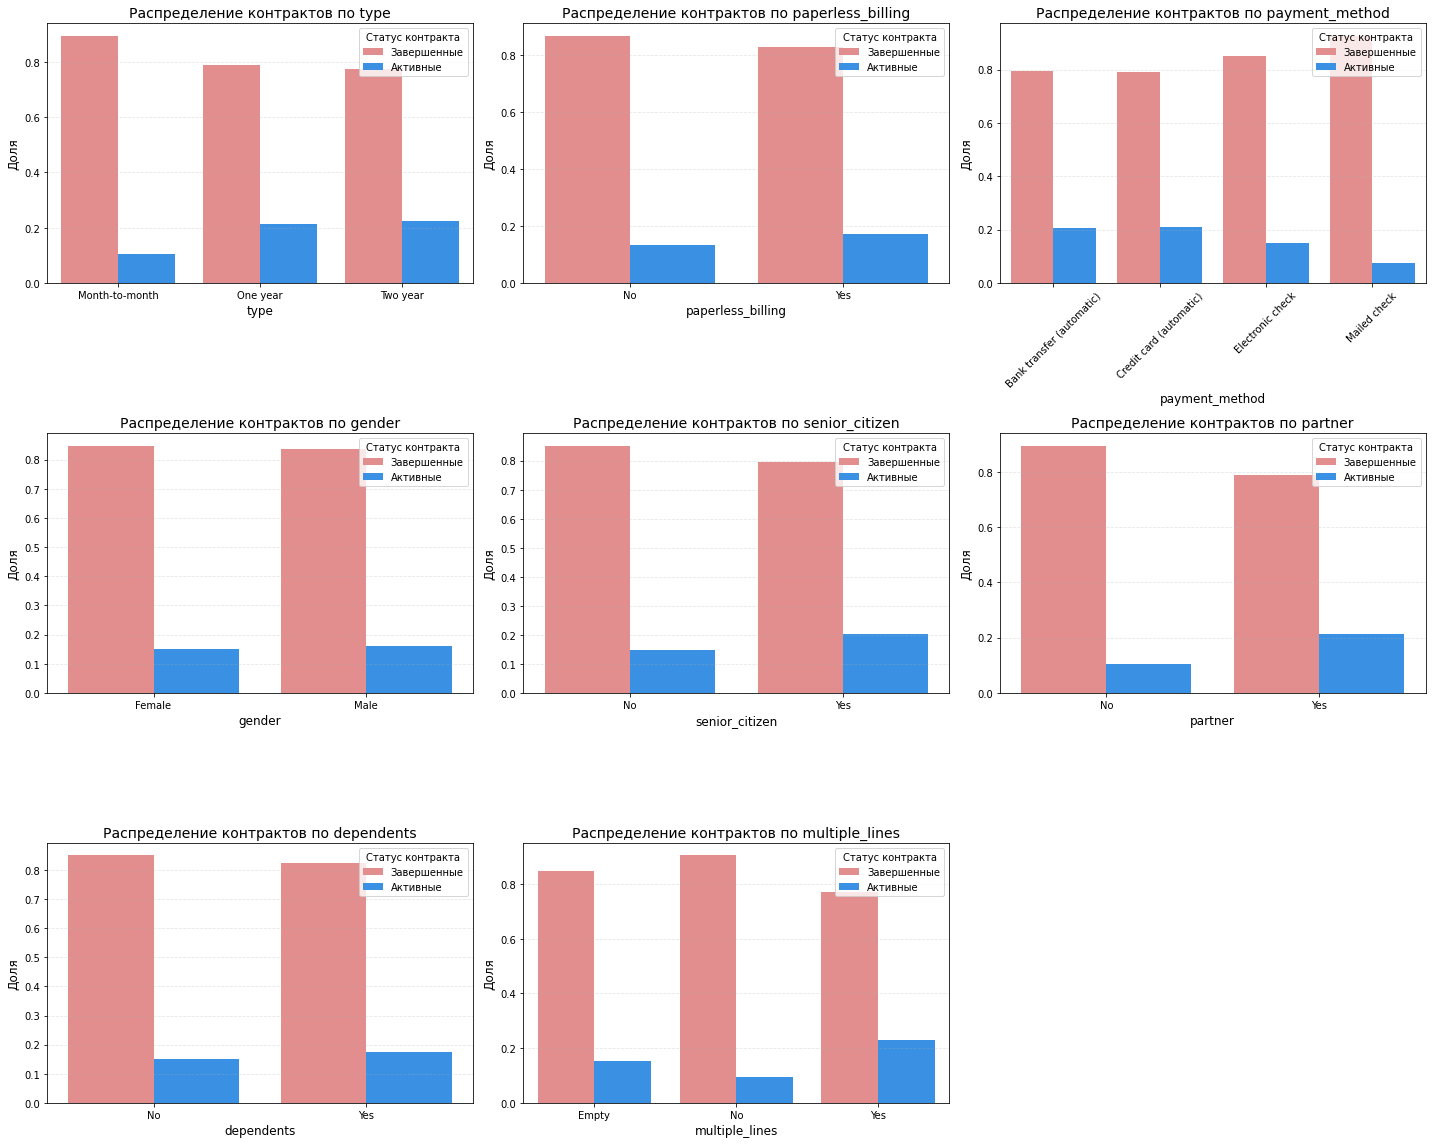

In [53]:
categorical_features = [
    'type', 'paperless_billing', 'payment_method', 'gender',
    'senior_citizen', 'partner', 'dependents', 'multiple_lines'
]
plt.figure(figsize=(20, 16))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    crosstab = pd.crosstab(
        merged_df[feature],
        merged_df['contract_active'],
        normalize='index'
    )
    crosstab_melted = crosstab.reset_index().melt(
        id_vars=[feature], 
        var_name='contract_active', 
        value_name='proportion'
    )
    sns.barplot(
        data=crosstab_melted,
        x=feature, 
        y='proportion',
        hue='contract_active',
        palette={0: 'lightcoral', 1: 'dodgerblue'}
    )
    plt.title(f'Распределение контрактов по {feature}', fontsize=14)
    plt.ylabel('Доля', fontsize=12)
    plt.xlabel(feature, fontsize=12)

    if len(merged_df[feature].unique()) > 3:
        plt.xticks(rotation=45)
    else:
        plt.xticks(rotation=0)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, ['Завершенные', 'Активные'], title='Статус контракта', fontsize=10)
    
    plt.grid(True, linestyle='--', alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Активные контракты (синие столбцы) - это клиенты, которые продолжают пользоваться услугами. Общая доля активных клиентов составляет около 15-20% от всей клиентской базы.

1. Тип подписки (type)  
Two year: ~20% клиентов остаются активными (наивысшая лояльность)  
One year: ~20% активных клиентов  
Month-to-month: ~10% активных клиентов (самая высокая текучесть)  
**Вывод: Долгосрочные контракты в 2 раза эффективнее удерживают клиентов по сравнению с месячными подписками.**

2. Электронный счет (paperless_billing)  
Yes: ~18% активных клиентов  
No: ~15% активных клиентов  
**Вывод: Электронные счета незначительно улучшают удержание клиентов.**

3. Способ оплаты (payment_method)  
Автоматические методы (Credit card, Bank transfer): ~20% активных  
Electronic check: ~15% активных  
Mailed check: ~10% активных  
**Вывод: Автоматизация платежей удваивает вероятность удержания клиента по сравнению с бумажными чеками.**

4. Пол клиента (gender)  
Male: ~17% активных  
Female: ~16% активных  
**Вывод: Влияние пола минимальное и статистически незначимое.**

5. Пенсионный статус (senior_citizen)  
Yes (пенсионеры): ~18% активных  
No: ~16% активных  
**Вывод: Пожилые клиенты демонстрируют немного большую лояльность.**

6. Семейное положение (partner)  
Yes (с партнером): ~20% активных  
No (одинокие): ~12% активных  
**Вывод: Наличие партнера значительно (на 67%) увеличивает вероятность сохранения контракта.**

7. Наличие детей (dependents)  
Yes (с детьми): ~18% активных  
No (без детей): ~16% активных  
**Вывод: Семьи с детьми показывают умеренно более высокую лояльность.**

8. Подключение нескольких линий (multiple_lines)  
Yes: ~22% активных (наивысший показатель)  
No: ~15% активных  
**Вывод: Клиенты с несколькими линиями на 47% чаще остаются лояльными.**



**Общие выводы:**  
Ключевые факторы удержания клиентов:
- долгосрочные контракты (эффект x2)
- автоматические платежи (эффект x2)
- наличие партнера (эффект +67%)
- несколько линий связи (эффект +47%)

Группы высокого риска (низкое удержание ~10-12%):
- месячные подписки
- бумажные чеки для оплаты
- одинокие клиенты
- клиенты с одной линией связи

Рекомендации:
- перевод клиентов на годовые/двухлетние контракты
- стимулировать переход на автоплатежи
- специальные предложения для пар и семей
- продвижение дополнительных линий и услуг
- особое внимание клиентам из групп риска в первые месяцы обслуживания

Большинство клиентов (80-85%) покидают сервис, что указывает на серьезные проблемы с удержанием, требующие системного подхода к улучшению клиентского опыта.

### Анализ мультиколлинеарности и отбор признаков.

In [54]:
# функция расчета корреляционной матрицы (коэффициент фи)
def corr_matrix(df,title,interval_cols):
    phik_matrix = df.phik_matrix(interval_cols=interval_cols)
    plt.figure(figsize=(16, 12))
    sns.heatmap(
        phik_matrix,          
        annot=True,          
        fmt=".2f",          
        cmap="Blues",       
        linewidths=0.5,        
        cbar_kws={'label': 'Коэффициент корреляции'} 
    )
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [55]:
merged_df_corr = merged_df.drop('customer_id', axis=1)

In [56]:
interval_cols = ['monthly_charges','total_charges','contract_duration']

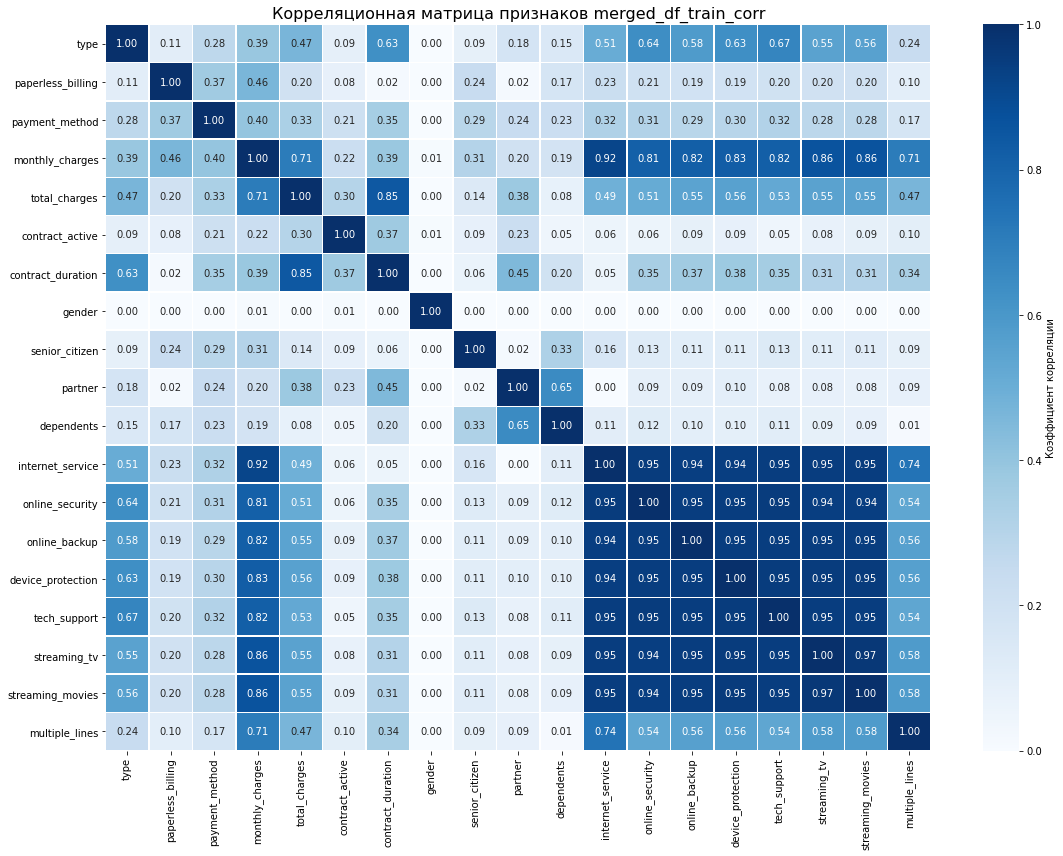

In [57]:
corr_matrix(merged_df_corr,'Корреляционная матрица признаков merged_df_train_corr',interval_cols)

Виден ряд признаков, которые имеют мультиколлинеарность, объединим их в единый признак, показывающий общее количество подключенных услуг.

In [58]:
merged_df_corr['connected_services_count'] = (
    merged_df_corr[['internet_service',
                          'online_security',
                          'online_backup',
                          'device_protection',
                          'tech_support',
                          'streaming_tv',
                          'streaming_movies']]
    .apply(lambda row: (row == 'Yes').sum(), axis=1)
)

# удаление исходных колонок с услугами
merged_df_corr.drop(columns=['internet_service', 'online_security', 'online_backup',
                                   'device_protection', 'tech_support', 'streaming_tv',
                                   'streaming_movies'], inplace=True)

In [59]:
merged_df_corr.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_active,contract_duration,gender,senior_citizen,partner,dependents,multiple_lines,connected_services_count
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,Yes,No,Empty,1
1,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,No,No,No,2
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,No,No,No,No,2
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,No,No,No,Empty,3
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,No,No,No,No,0


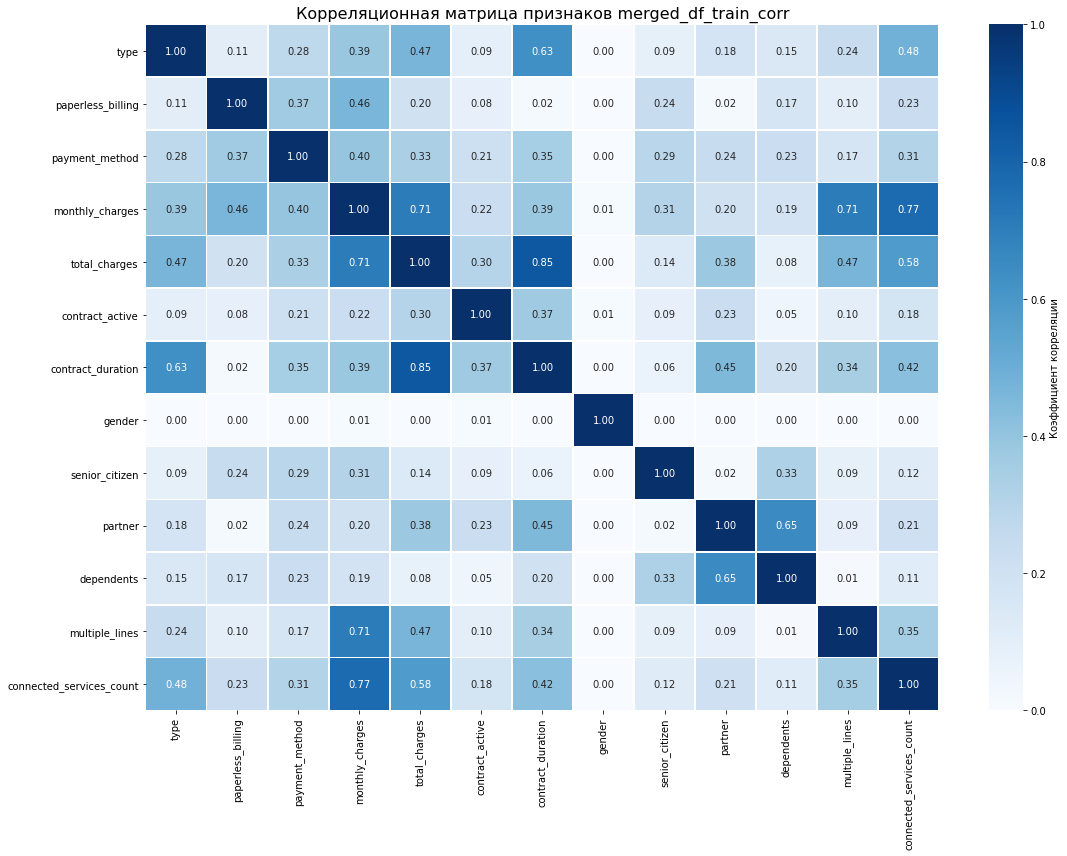

In [60]:
corr_matrix(merged_df_corr,'Корреляционная матрица признаков merged_df_train_corr',interval_cols)

Длительность контракта имеет наибольшую корреляцию с активностью, что подтверждает важность удержания клиентов на раннем этапе.

Клиенты с более высокими тратами склонны оставаться активными.

Наличие партнера значимо коррелирует с лояльностью.

Пол и возраст имеют минимальное влияние.

## Обучение моделей

### Подготовка данных

In [61]:
features = merged_df_corr.drop('contract_active', axis=1)
target = merged_df_corr['contract_active']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size = TEST_SIZE, 
    stratify = target, 
    random_state = RANDOM_STATE
)


In [63]:
display(X_train.head())
X_train.shape

,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration,gender,senior_citizen,partner,dependents,multiple_lines,connected_services_count
5236,Two year,Yes,Bank transfer (automatic),96.25,5717.25,1676,Male,No,Yes,Yes,Yes,3
3320,Month-to-month,Yes,Electronic check,85.65,653.51,215,Male,No,No,No,Yes,1
1783,Month-to-month,Yes,Credit card (automatic),84.25,3639.60,1218,Female,No,No,No,No,3
1990,Month-to-month,Yes,Electronic check,45.70,137.10,92,Female,No,Yes,Yes,No,0
5495,Month-to-month,No,Mailed check,55.70,60.16,31,Male,No,Yes,No,No,2


(5254, 12)

In [64]:
display(X_test.head())
X_test.shape

,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration,gender,senior_citizen,partner,dependents,multiple_lines,connected_services_count
2260,Month-to-month,Yes,Bank transfer (automatic),98.15,883.35,276,Female,No,No,No,No,5
5360,Month-to-month,Yes,Electronic check,78.90,1972.50,761,Male,No,Yes,No,Yes,1
2261,Two year,Yes,Bank transfer (automatic),114.95,5801.53,1491,Male,No,No,No,Yes,6
6485,Month-to-month,No,Electronic check,48.95,195.80,123,Male,No,No,Yes,No,1
3878,Month-to-month,No,Electronic check,74.95,1124.25,457,Male,No,No,No,No,1


(1752, 12)

In [65]:
y_train.shape

(5254,)

In [66]:
y_test.shape

(1752,)

### Настройка моделей

In [67]:
# функция для поиска гиперпараметров и оценки времени
def optimize_hyperparameters(X_train, y_train, pipeline, param_grid, cv=4, 
                             scoring='roc_auc', n_iter=10, verbose=1):
    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=verbose,
        return_train_score=True
    )
    start_time = time.time()
    search.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    return search, train_time

In [68]:
# функция для уточнения диапазона значений гиперпараметров
def refine_parameter_range(current_range, best_value, min_step=0.01, int_type=False):
    min_val, mid_val, max_val = current_range

    if (mid_val - min_val) <= min_step:
        return current_range, True

    if best_value == min_val:
        new_max = mid_val
        new_mid = min_val + (new_max - min_val) / 2
        new_range = [min_val, new_mid, new_max]
    elif best_value == max_val:
        new_min = mid_val
        new_mid = new_min + (max_val - new_min) / 2
        new_range = [new_min, new_mid, max_val]
    else:
        new_range = current_range
    if int_type:
        new_range = [int(val) for val in new_range]
    
    return new_range, False

In [69]:
# функция для визуализации и вывода результатов
def display_and_visualize_results(search, train_time, model_name, show_cv_results=True):

    print(f"\nМодель: {model_name}")
    print(f"Лучшая метрика ({search.scoring}): {search.best_score_:.4f}")
    print(f"Время обучения: {train_time:.2f} секунд")
    print("Лучшие параметры:")
    
    for param, value in search.best_params_.items():
        print(f"  {param}: {value}")
    
    print('-' * 50)

    if show_cv_results:
        cv_results = pd.DataFrame(search.cv_results_)
        display_cols = ['params', 'mean_test_score', 'mean_train_score', 
                         'std_test_score', 'rank_test_score', 'mean_fit_time']
        existing_cols = [col for col in display_cols if col in cv_results.columns]
        display(cv_results[existing_cols].sort_values('rank_test_score').head(10))

    cv_results = pd.DataFrame(search.cv_results_)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(cv_results['mean_train_score'], 'o-', label='Train', color='blue', alpha=0.7)
    plt.plot(cv_results['mean_test_score'], 'o-', label='Test', color='green', alpha=0.7)
    plt.xlabel('Итерация')
    plt.ylabel(search.scoring)
    plt.title(f'Значения метрики {search.scoring} для {model_name}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.subplot(1, 2, 2)
    overfitting = cv_results['mean_train_score'] - cv_results['mean_test_score']
    bars = plt.bar(range(len(overfitting)), overfitting, color='purple', alpha=0.6)

    for i, bar in enumerate(bars):
        if overfitting[i] > 0.05:
            bar.set_color('red')
        elif overfitting[i] < 0.01:
            bar.set_color('green')
    
    plt.xlabel('Итерация')
    plt.ylabel('Train - Test')
    plt.title('Разница между Train и Test (переобучение)')
    plt.grid(True, linestyle='--', axis='y', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return search.best_score_, search.best_params_


In [70]:
features_categories = ([
    'type',
    'paperless_billing',
    'payment_method',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines'
])
features_numeric = ['monthly_charges','total_charges','contract_duration','connected_services_count']

### Модель LogisticRegeression

In [71]:
all_searches = []
all_times = []

In [72]:
column_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), features_categories),
    ('std', PowerTransformer(), features_numeric)
], remainder='drop', verbose_feature_names_out=False)

In [73]:
model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

In [74]:
pipeline = Pipeline([
    ('transform', column_trans),
    ('clf', model)
])

In [75]:
C_range = [0.001, 0.05, 1.0]
max_iterations = 5
is_converged = False

Запуск поиска оптимальных параметров для логистической регрессии

Итерация 1
Текущий диапазон C: [0.001, 0.05, 1.0]
Fitting 4 folds for each of 9 candidates, totalling 36 fits

Модель: LogisticRegression (Итерация 1)
Лучшая метрика (roc_auc): 0.7142
Время обучения: 21.94 секунд
Лучшие параметры:
  clf__solver: newton-cg
  clf__C: 1.0
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
8,"{'clf__solver': 'newton-cg', 'clf__C': 1.0}",0.714230,0.727349,0.007181,1,0.354918
7,"{'clf__solver': 'lbfgs', 'clf__C': 1.0}",0.714181,0.727344,0.007194,2,0.574644
6,"{'clf__solver': 'liblinear', 'clf__C': 1.0}",0.714173,0.727313,0.007132,3,0.229641
5,"{'clf__solver': 'newton-cg', 'clf__C': 0.05}",0.712207,0.724947,0.008661,4,0.477828
4,"{'clf__solver': 'lbfgs', 'clf__C': 0.05}",0.712171,0.724935,0.008671,5,0.467922
3,"{'clf__solver': 'liblinear', 'clf__C': 0.05}",0.711461,0.724096,0.007942,6,0.221132
2,"{'clf__solver': 'newton-cg', 'clf__C': 0.001}",0.678544,0.683036,0.010513,7,0.369378
1,"{'clf__solver': 'lbfgs', 'clf__C': 0.001}",0.678539,0.683030,0.010511,8,0.275110
0,"{'clf__solver': 'liblinear', 'clf__C': 0.001}",0.675864,0.680235,0.009733,9,0.165579


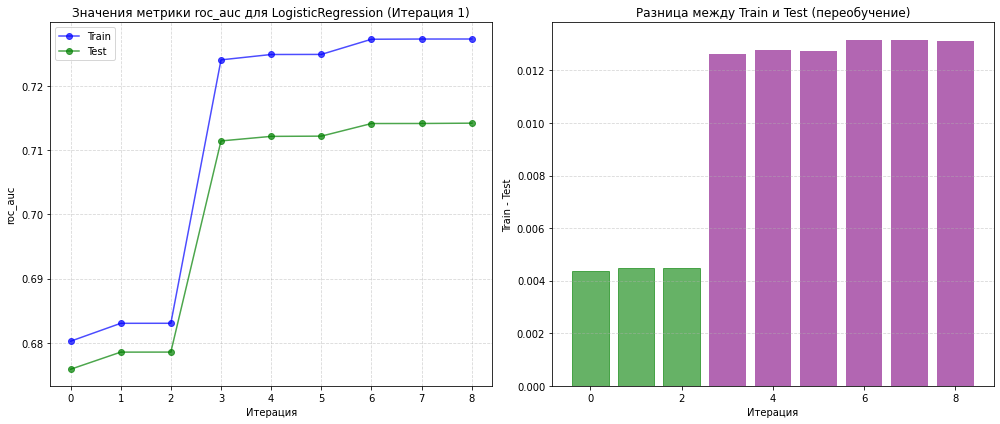

Лучшее значение C: 1.0

Итерация 2
Текущий диапазон C: [0.05, 0.525, 1.0]
Fitting 4 folds for each of 9 candidates, totalling 36 fits

Модель: LogisticRegression (Итерация 2)
Лучшая метрика (roc_auc): 0.7142
Время обучения: 24.96 секунд
Лучшие параметры:
  clf__solver: newton-cg
  clf__C: 1.0
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
8,"{'clf__solver': 'newton-cg', 'clf__C': 1.0}",0.714230,0.727349,0.007181,1,0.543837
7,"{'clf__solver': 'lbfgs', 'clf__C': 1.0}",0.714181,0.727344,0.007194,2,0.649423
6,"{'clf__solver': 'liblinear', 'clf__C': 1.0}",0.714173,0.727313,0.007132,3,0.230954
5,"{'clf__solver': 'newton-cg', 'clf__C': 0.525}",0.714125,0.727214,0.007116,4,0.490895
4,"{'clf__solver': 'lbfgs', 'clf__C': 0.525}",0.714041,0.727200,0.007136,5,0.706279
3,"{'clf__solver': 'liblinear', 'clf__C': 0.525}",0.713982,0.727151,0.007143,6,0.173028
2,"{'clf__solver': 'newton-cg', 'clf__C': 0.05}",0.712207,0.724947,0.008661,7,0.428023
1,"{'clf__solver': 'lbfgs', 'clf__C': 0.05}",0.712171,0.724935,0.008671,8,0.400952
0,"{'clf__solver': 'liblinear', 'clf__C': 0.05}",0.711461,0.724096,0.007942,9,0.166448


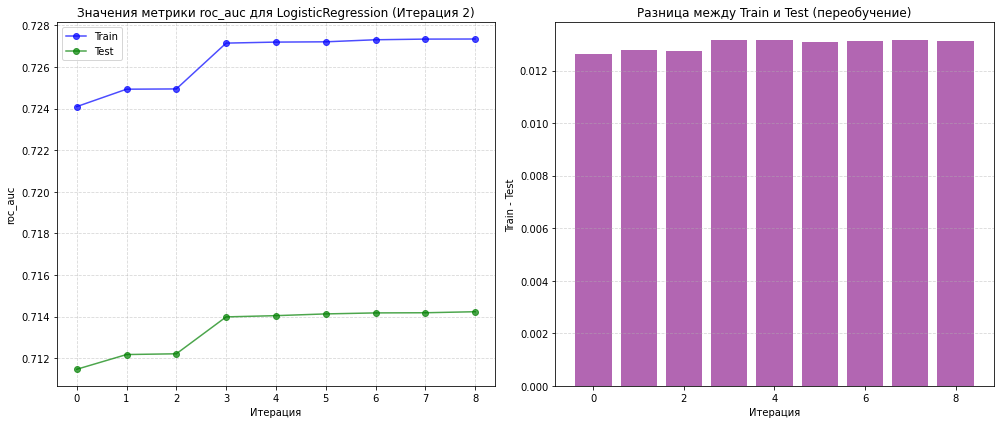

Лучшее значение C: 1.0

Итерация 3
Текущий диапазон C: [0.525, 0.7625, 1.0]
Fitting 4 folds for each of 9 candidates, totalling 36 fits

Модель: LogisticRegression (Итерация 3)
Лучшая метрика (roc_auc): 0.7142
Время обучения: 25.38 секунд
Лучшие параметры:
  clf__solver: newton-cg
  clf__C: 1.0
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
8,"{'clf__solver': 'newton-cg', 'clf__C': 1.0}",0.714230,0.727349,0.007181,1,0.470112
3,"{'clf__solver': 'liblinear', 'clf__C': 0.7625}",0.714182,0.727266,0.007065,2,0.230016
7,"{'clf__solver': 'lbfgs', 'clf__C': 1.0}",0.714181,0.727344,0.007194,3,0.639008
6,"{'clf__solver': 'liblinear', 'clf__C': 1.0}",0.714173,0.727313,0.007132,4,0.212576
5,"{'clf__solver': 'newton-cg', 'clf__C': 0.7625}",0.714144,0.727314,0.007169,5,0.446757
4,"{'clf__solver': 'lbfgs', 'clf__C': 0.7625}",0.714137,0.727301,0.007177,6,0.617830
2,"{'clf__solver': 'newton-cg', 'clf__C': 0.525}",0.714125,0.727214,0.007116,7,0.497596
1,"{'clf__solver': 'lbfgs', 'clf__C': 0.525}",0.714041,0.727200,0.007136,8,0.595830
0,"{'clf__solver': 'liblinear', 'clf__C': 0.525}",0.713982,0.727151,0.007143,9,0.189262


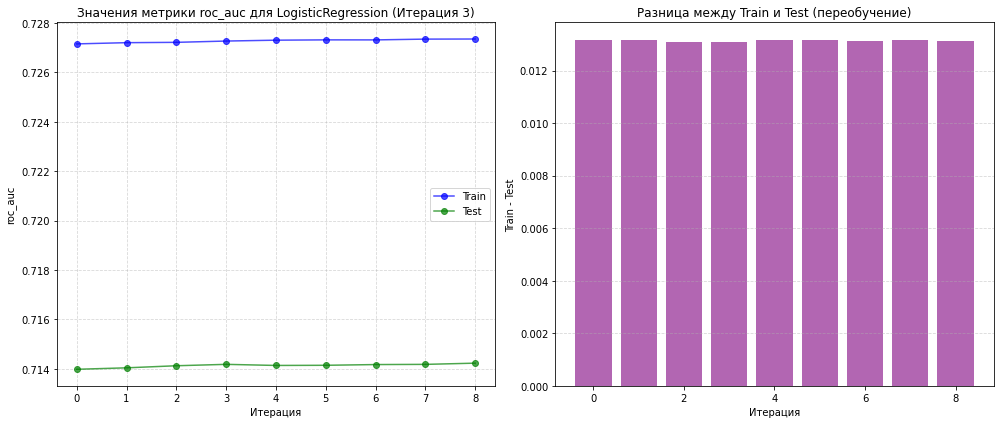

Лучшее значение C: 1.0

Итерация 4
Текущий диапазон C: [0.7625, 0.88125, 1.0]
Fitting 4 folds for each of 9 candidates, totalling 36 fits

Модель: LogisticRegression (Итерация 4)
Лучшая метрика (roc_auc): 0.7142
Время обучения: 25.22 секунд
Лучшие параметры:
  clf__solver: newton-cg
  clf__C: 1.0
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
8,"{'clf__solver': 'newton-cg', 'clf__C': 1.0}",0.714230,0.727349,0.007181,1,0.418047
5,"{'clf__solver': 'newton-cg', 'clf__C': 0.88125}",0.714195,0.727324,0.007182,2,0.497832
3,"{'clf__solver': 'liblinear', 'clf__C': 0.88125}",0.714184,0.727294,0.007159,3,0.190536
0,"{'clf__solver': 'liblinear', 'clf__C': 0.7625}",0.714182,0.727266,0.007065,4,0.177321
7,"{'clf__solver': 'lbfgs', 'clf__C': 1.0}",0.714181,0.727344,0.007194,5,0.620784
6,"{'clf__solver': 'liblinear', 'clf__C': 1.0}",0.714173,0.727313,0.007132,6,0.228807
2,"{'clf__solver': 'newton-cg', 'clf__C': 0.7625}",0.714144,0.727314,0.007169,7,0.515874
4,"{'clf__solver': 'lbfgs', 'clf__C': 0.88125}",0.714141,0.727322,0.007166,8,0.641114
1,"{'clf__solver': 'lbfgs', 'clf__C': 0.7625}",0.714137,0.727301,0.007177,9,0.578188


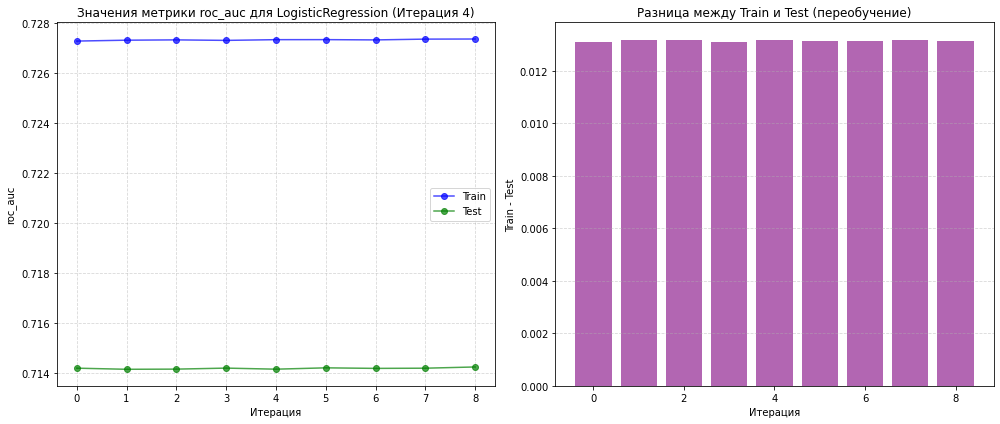

Лучшее значение C: 1.0

Итерация 5
Текущий диапазон C: [0.88125, 0.940625, 1.0]
Fitting 4 folds for each of 9 candidates, totalling 36 fits

Модель: LogisticRegression (Итерация 5)
Лучшая метрика (roc_auc): 0.7142
Время обучения: 25.82 секунд
Лучшие параметры:
  clf__solver: newton-cg
  clf__C: 1.0
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
8,"{'clf__solver': 'newton-cg', 'clf__C': 1.0}",0.714230,0.727349,0.007181,1,0.498909
2,"{'clf__solver': 'newton-cg', 'clf__C': 0.88125}",0.714195,0.727324,0.007182,2,0.521212
5,"{'clf__solver': 'newton-cg', 'clf__C': 0.940625}",0.714188,0.727335,0.007171,3,0.454999
0,"{'clf__solver': 'liblinear', 'clf__C': 0.88125}",0.714184,0.727294,0.007159,4,0.184787
7,"{'clf__solver': 'lbfgs', 'clf__C': 1.0}",0.714181,0.727344,0.007194,5,0.579949
3,"{'clf__solver': 'liblinear', 'clf__C': 0.940625}",0.714177,0.727297,0.007145,6,0.169123
6,"{'clf__solver': 'liblinear', 'clf__C': 1.0}",0.714173,0.727313,0.007132,7,0.222025
4,"{'clf__solver': 'lbfgs', 'clf__C': 0.940625}",0.714152,0.727334,0.007189,8,0.697390
1,"{'clf__solver': 'lbfgs', 'clf__C': 0.88125}",0.714141,0.727322,0.007166,9,0.593971


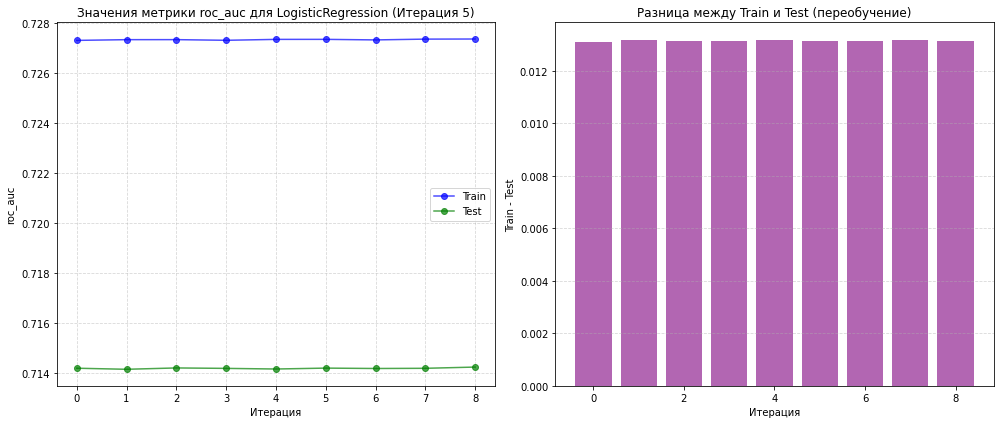

Лучшее значение C: 1.0


In [76]:
print("Запуск поиска оптимальных параметров для логистической регрессии")
print("=" * 80)

for iteration in range(max_iterations):
    print(f"\nИтерация {iteration+1}")
    print(f"Текущий диапазон C: {C_range}")

    param_grid = {
        'clf__solver': ['liblinear', 'lbfgs', 'newton-cg'],
        'clf__C': C_range
    }

    search, train_time = optimize_hyperparameters(
        X_train, y_train, pipeline, param_grid, cv=4, 
        n_iter=9
    )

    all_searches.append(search)
    all_times.append(train_time)
    _, best_params = display_and_visualize_results(
        search, train_time, f'LogisticRegression (Итерация {iteration+1})'
    )
    best_C = best_params['clf__C']
    print(f"Лучшее значение C: {best_C}")
    C_range, is_converged = refine_parameter_range(C_range, best_C, min_step=0.01)

    if is_converged:
        print("\n" + "=" * 80)
        print("Достигнута желаемая точность. Останавливаем итерации.")
        print("=" * 80)
        break


Финальные результаты:

Модель: LogisticRegression (Финальная)
Лучшая метрика (roc_auc): 0.7142
Время обучения: 25.82 секунд
Лучшие параметры:
  clf__solver: newton-cg
  clf__C: 1.0
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
8,"{'clf__solver': 'newton-cg', 'clf__C': 1.0}",0.714230,0.727349,0.007181,1,0.498909
2,"{'clf__solver': 'newton-cg', 'clf__C': 0.88125}",0.714195,0.727324,0.007182,2,0.521212
5,"{'clf__solver': 'newton-cg', 'clf__C': 0.940625}",0.714188,0.727335,0.007171,3,0.454999
0,"{'clf__solver': 'liblinear', 'clf__C': 0.88125}",0.714184,0.727294,0.007159,4,0.184787
7,"{'clf__solver': 'lbfgs', 'clf__C': 1.0}",0.714181,0.727344,0.007194,5,0.579949
3,"{'clf__solver': 'liblinear', 'clf__C': 0.940625}",0.714177,0.727297,0.007145,6,0.169123
6,"{'clf__solver': 'liblinear', 'clf__C': 1.0}",0.714173,0.727313,0.007132,7,0.222025
4,"{'clf__solver': 'lbfgs', 'clf__C': 0.940625}",0.714152,0.727334,0.007189,8,0.697390
1,"{'clf__solver': 'lbfgs', 'clf__C': 0.88125}",0.714141,0.727322,0.007166,9,0.593971


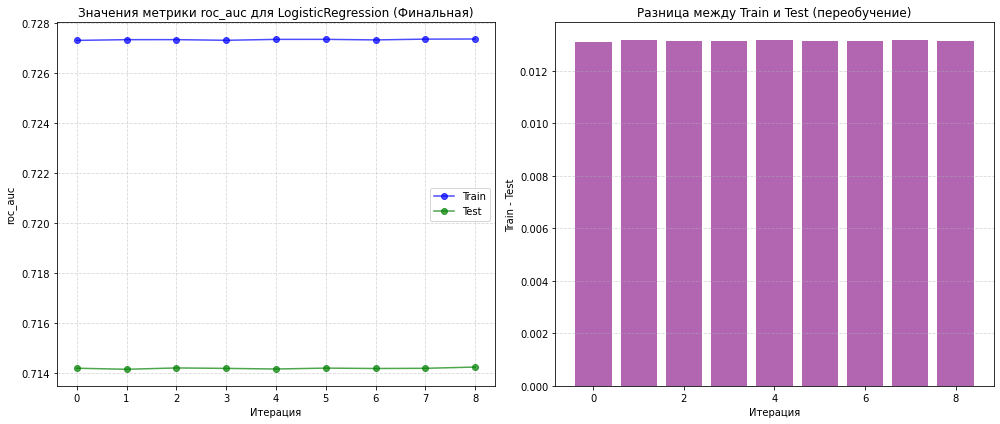

Всего выполнено итераций: 5
Общее затраченное время: 123.31 секунд


In [77]:
print("\nФинальные результаты:")
best_score, best_params = display_and_visualize_results(
    all_searches[-1], all_times[-1], 'LogisticRegression (Финальная)'
)
print(f"Всего выполнено итераций: {len(all_searches)}")
print(f"Общее затраченное время: {sum(all_times):.2f} секунд")

best_model_lr = all_searches[-1].best_estimator_

### Модель RandomForestClassifier

In [78]:
column_trans = ColumnTransformer([
    ('ohe', OrdinalEncoder(), features_categories), 
    ('std', MaxAbsScaler(), features_numeric)
], remainder='drop', verbose_feature_names_out=False)

In [79]:
model = RandomForestClassifier(random_state=RANDOM_STATE)

In [80]:
pipeline = Pipeline([
    ('transform', column_trans),
    ('clf', model)
])

In [81]:
max_depth_range = [1, 25, 50]
n_estimators_range = [10, 50, 100]
max_iterations = 5
is_max_depth_converged = False
is_n_estimators_converged = False

Запуск итеративного поиска оптимальных параметров для RandomForestClassifier

Итерация 1
Текущие диапазоны: max_depth: [1, 25, 50], n_estimators: [10, 50, 100]
Fitting 4 folds for each of 9 candidates, totalling 36 fits

Модель: RandomForestClassifier (Итерация 1)
Лучшая метрика (roc_auc): 0.8087
Время обучения: 13.52 секунд
Лучшие параметры:
  clf__n_estimators: 50
  clf__max_features: None
  clf__max_depth: 25
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
2,"{'clf__n_estimators': 50, 'clf__max_features':...",0.808688,1.000000,0.012038,1,0.620634
5,"{'clf__n_estimators': 100, 'clf__max_features'...",0.800463,1.000000,0.018704,2,0.491503
6,"{'clf__n_estimators': 100, 'clf__max_features'...",0.800463,1.000000,0.018704,2,0.483654
3,"{'clf__n_estimators': 50, 'clf__max_features':...",0.794376,1.000000,0.016213,4,0.252185
1,"{'clf__n_estimators': 10, 'clf__max_features':...",0.753140,0.999456,0.019429,5,0.069941
4,"{'clf__n_estimators': 10, 'clf__max_features':...",0.753140,0.999456,0.019429,5,0.067632
0,"{'clf__n_estimators': 100, 'clf__max_features'...",0.704866,0.714812,0.019712,7,0.207062
8,"{'clf__n_estimators': 50, 'clf__max_features':...",0.704121,0.714300,0.020666,8,0.113817
7,"{'clf__n_estimators': 100, 'clf__max_features'...",0.690796,0.703397,0.018393,9,0.291065


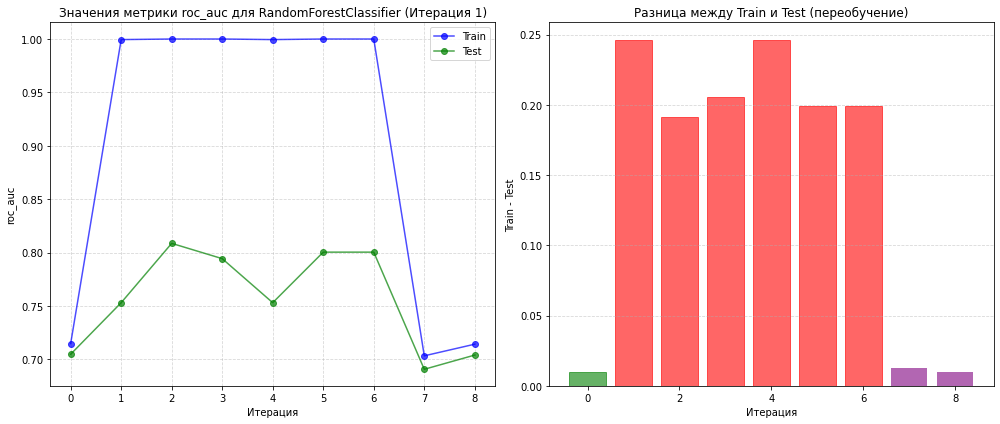

Лучшие значения: max_depth=25, n_estimators=50

Итерация 2
Текущие диапазоны: max_depth: [1, 25, 50], n_estimators: [10, 50, 100]
Fitting 4 folds for each of 9 candidates, totalling 36 fits

Модель: RandomForestClassifier (Итерация 2)
Лучшая метрика (roc_auc): 0.8087
Время обучения: 13.56 секунд
Лучшие параметры:
  clf__n_estimators: 50
  clf__max_features: None
  clf__max_depth: 25
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
2,"{'clf__n_estimators': 50, 'clf__max_features':...",0.808688,1.000000,0.012038,1,0.609059
5,"{'clf__n_estimators': 100, 'clf__max_features'...",0.800463,1.000000,0.018704,2,0.501131
6,"{'clf__n_estimators': 100, 'clf__max_features'...",0.800463,1.000000,0.018704,2,0.502030
3,"{'clf__n_estimators': 50, 'clf__max_features':...",0.794376,1.000000,0.016213,4,0.255951
1,"{'clf__n_estimators': 10, 'clf__max_features':...",0.753140,0.999456,0.019429,5,0.067801
4,"{'clf__n_estimators': 10, 'clf__max_features':...",0.753140,0.999456,0.019429,5,0.068948
0,"{'clf__n_estimators': 100, 'clf__max_features'...",0.704866,0.714812,0.019712,7,0.214699
8,"{'clf__n_estimators': 50, 'clf__max_features':...",0.704121,0.714300,0.020666,8,0.113867
7,"{'clf__n_estimators': 100, 'clf__max_features'...",0.690796,0.703397,0.018393,9,0.280583


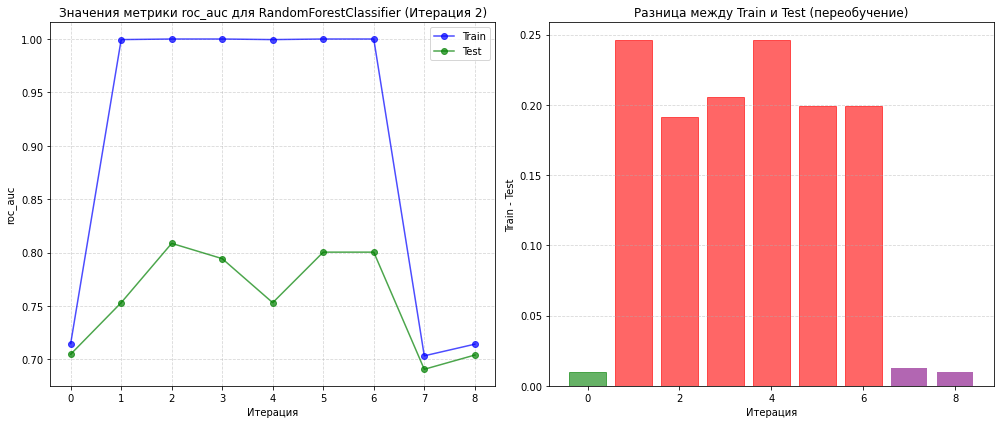

Лучшие значения: max_depth=25, n_estimators=50

Итерация 3
Текущие диапазоны: max_depth: [1, 25, 50], n_estimators: [10, 50, 100]
Fitting 4 folds for each of 9 candidates, totalling 36 fits

Модель: RandomForestClassifier (Итерация 3)
Лучшая метрика (roc_auc): 0.8087
Время обучения: 13.53 секунд
Лучшие параметры:
  clf__n_estimators: 50
  clf__max_features: None
  clf__max_depth: 25
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
2,"{'clf__n_estimators': 50, 'clf__max_features':...",0.808688,1.000000,0.012038,1,0.612975
5,"{'clf__n_estimators': 100, 'clf__max_features'...",0.800463,1.000000,0.018704,2,0.485114
6,"{'clf__n_estimators': 100, 'clf__max_features'...",0.800463,1.000000,0.018704,2,0.485979
3,"{'clf__n_estimators': 50, 'clf__max_features':...",0.794376,1.000000,0.016213,4,0.264302
1,"{'clf__n_estimators': 10, 'clf__max_features':...",0.753140,0.999456,0.019429,5,0.061077
4,"{'clf__n_estimators': 10, 'clf__max_features':...",0.753140,0.999456,0.019429,5,0.072306
0,"{'clf__n_estimators': 100, 'clf__max_features'...",0.704866,0.714812,0.019712,7,0.212247
8,"{'clf__n_estimators': 50, 'clf__max_features':...",0.704121,0.714300,0.020666,8,0.115558
7,"{'clf__n_estimators': 100, 'clf__max_features'...",0.690796,0.703397,0.018393,9,0.281779


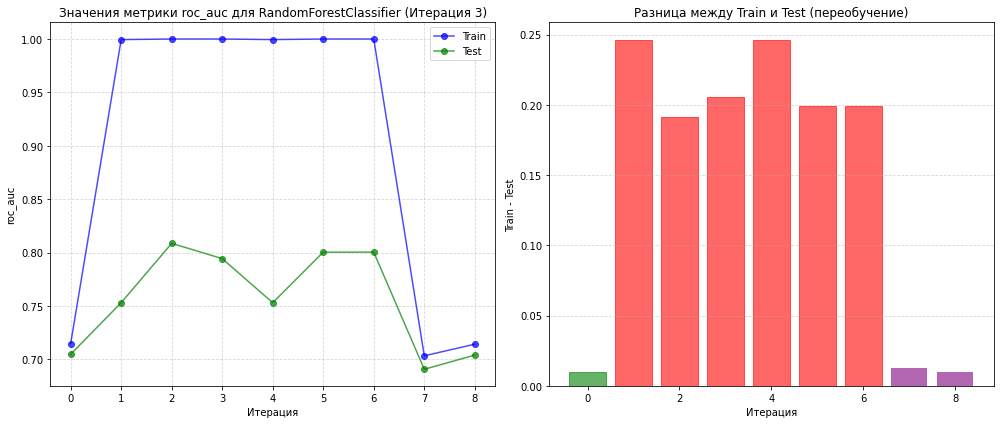

Лучшие значения: max_depth=25, n_estimators=50

Итерация 4
Текущие диапазоны: max_depth: [1, 25, 50], n_estimators: [10, 50, 100]
Fitting 4 folds for each of 9 candidates, totalling 36 fits

Модель: RandomForestClassifier (Итерация 4)
Лучшая метрика (roc_auc): 0.8087
Время обучения: 13.68 секунд
Лучшие параметры:
  clf__n_estimators: 50
  clf__max_features: None
  clf__max_depth: 25
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
2,"{'clf__n_estimators': 50, 'clf__max_features':...",0.808688,1.000000,0.012038,1,0.611242
5,"{'clf__n_estimators': 100, 'clf__max_features'...",0.800463,1.000000,0.018704,2,0.491763
6,"{'clf__n_estimators': 100, 'clf__max_features'...",0.800463,1.000000,0.018704,2,0.500483
3,"{'clf__n_estimators': 50, 'clf__max_features':...",0.794376,1.000000,0.016213,4,0.250408
1,"{'clf__n_estimators': 10, 'clf__max_features':...",0.753140,0.999456,0.019429,5,0.076645
4,"{'clf__n_estimators': 10, 'clf__max_features':...",0.753140,0.999456,0.019429,5,0.067123
0,"{'clf__n_estimators': 100, 'clf__max_features'...",0.704866,0.714812,0.019712,7,0.221792
8,"{'clf__n_estimators': 50, 'clf__max_features':...",0.704121,0.714300,0.020666,8,0.114627
7,"{'clf__n_estimators': 100, 'clf__max_features'...",0.690796,0.703397,0.018393,9,0.290522


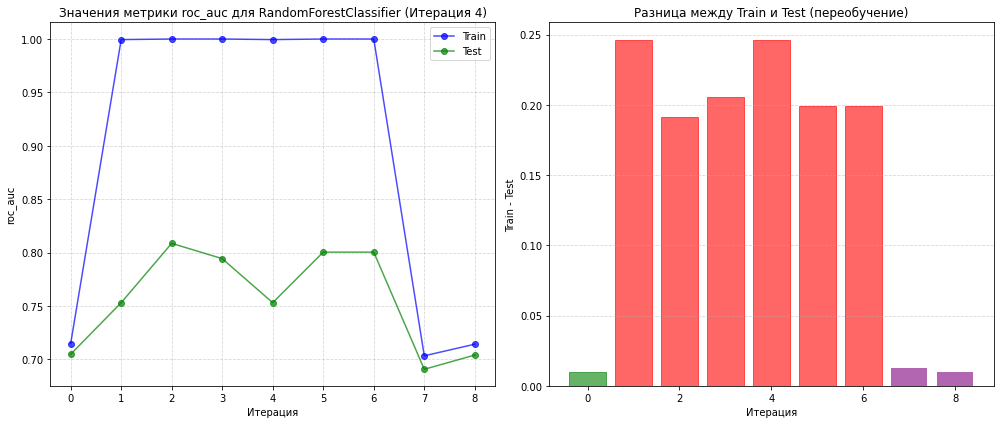

Лучшие значения: max_depth=25, n_estimators=50

Итерация 5
Текущие диапазоны: max_depth: [1, 25, 50], n_estimators: [10, 50, 100]
Fitting 4 folds for each of 9 candidates, totalling 36 fits

Модель: RandomForestClassifier (Итерация 5)
Лучшая метрика (roc_auc): 0.8087
Время обучения: 13.84 секунд
Лучшие параметры:
  clf__n_estimators: 50
  clf__max_features: None
  clf__max_depth: 25
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
2,"{'clf__n_estimators': 50, 'clf__max_features':...",0.808688,1.000000,0.012038,1,0.641864
5,"{'clf__n_estimators': 100, 'clf__max_features'...",0.800463,1.000000,0.018704,2,0.504662
6,"{'clf__n_estimators': 100, 'clf__max_features'...",0.800463,1.000000,0.018704,2,0.492048
3,"{'clf__n_estimators': 50, 'clf__max_features':...",0.794376,1.000000,0.016213,4,0.265214
1,"{'clf__n_estimators': 10, 'clf__max_features':...",0.753140,0.999456,0.019429,5,0.068590
4,"{'clf__n_estimators': 10, 'clf__max_features':...",0.753140,0.999456,0.019429,5,0.069656
0,"{'clf__n_estimators': 100, 'clf__max_features'...",0.704866,0.714812,0.019712,7,0.224190
8,"{'clf__n_estimators': 50, 'clf__max_features':...",0.704121,0.714300,0.020666,8,0.111320
7,"{'clf__n_estimators': 100, 'clf__max_features'...",0.690796,0.703397,0.018393,9,0.285687


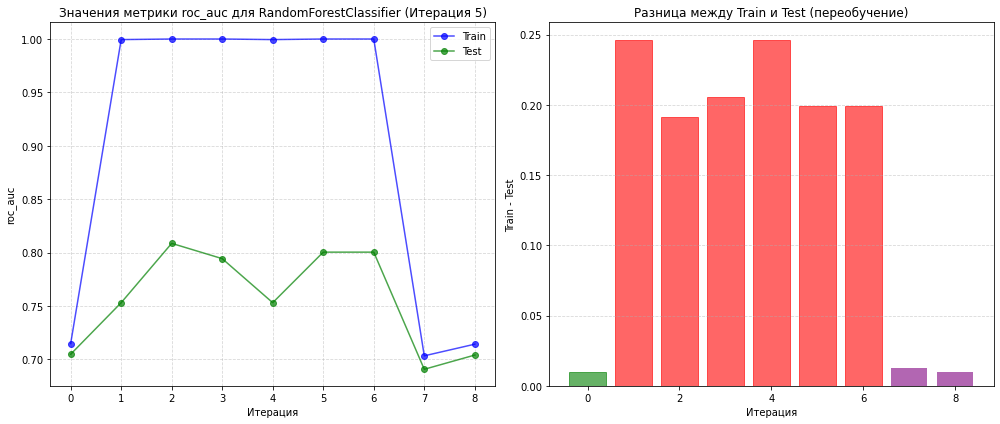

Лучшие значения: max_depth=25, n_estimators=50


In [82]:
print("Запуск итеративного поиска оптимальных параметров для RandomForestClassifier")
print("=" * 80)

for iteration in range(max_iterations):
    print(f"\nИтерация {iteration+1}")
    print(f"Текущие диапазоны: max_depth: {max_depth_range}, n_estimators: {n_estimators_range}")
    param_grid = {
        'clf__max_features': ['sqrt', 'log2', None],
        'clf__max_depth': max_depth_range,
        'clf__n_estimators': n_estimators_range,
    }

    search, train_time = optimize_hyperparameters(
        X_train, y_train, pipeline, param_grid, cv=4, 
        n_iter=9 
    )

    all_searches.append(search)
    all_times.append(train_time)

    _, best_params = display_and_visualize_results(
        search, train_time, f'RandomForestClassifier (Итерация {iteration+1})'
    )
    
    best_max_depth = best_params['clf__max_depth']
    best_n_estimators = best_params['clf__n_estimators']
    print(f"Лучшие значения: max_depth={best_max_depth}, n_estimators={best_n_estimators}")
    
    max_depth_range, is_max_depth_converged = refine_parameter_range(
        max_depth_range, best_max_depth, min_step=5, int_type=True
    )
    
    n_estimators_range, is_n_estimators_converged = refine_parameter_range(
        n_estimators_range, best_n_estimators, min_step=10, int_type=True
    )
    
    if is_max_depth_converged and is_n_estimators_converged:
        print("\n" + "=" * 80)
        print("Достигнута желаемая точность. Останавливаем итерации.")
        print("=" * 80)
        break


Финальные результаты:

Модель: RandomForestClassifier (Финальная)
Лучшая метрика (roc_auc): 0.8087
Время обучения: 13.84 секунд
Лучшие параметры:
  clf__n_estimators: 50
  clf__max_features: None
  clf__max_depth: 25
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
2,"{'clf__n_estimators': 50, 'clf__max_features':...",0.808688,1.000000,0.012038,1,0.641864
5,"{'clf__n_estimators': 100, 'clf__max_features'...",0.800463,1.000000,0.018704,2,0.504662
6,"{'clf__n_estimators': 100, 'clf__max_features'...",0.800463,1.000000,0.018704,2,0.492048
3,"{'clf__n_estimators': 50, 'clf__max_features':...",0.794376,1.000000,0.016213,4,0.265214
1,"{'clf__n_estimators': 10, 'clf__max_features':...",0.753140,0.999456,0.019429,5,0.068590
4,"{'clf__n_estimators': 10, 'clf__max_features':...",0.753140,0.999456,0.019429,5,0.069656
0,"{'clf__n_estimators': 100, 'clf__max_features'...",0.704866,0.714812,0.019712,7,0.224190
8,"{'clf__n_estimators': 50, 'clf__max_features':...",0.704121,0.714300,0.020666,8,0.111320
7,"{'clf__n_estimators': 100, 'clf__max_features'...",0.690796,0.703397,0.018393,9,0.285687


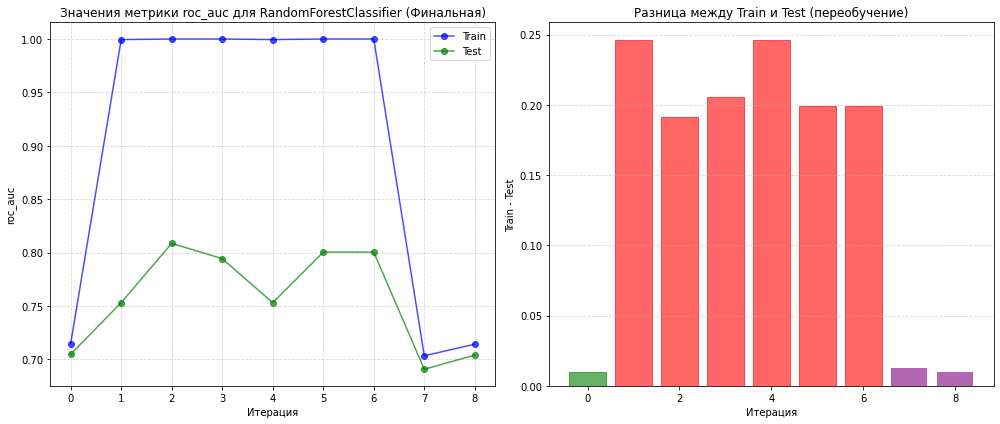

Всего выполнено итераций: 10
Общее затраченное время: 191.44 секунд


In [83]:
print("\nФинальные результаты:")
best_score, best_params = display_and_visualize_results(
    all_searches[-1], all_times[-1], 'RandomForestClassifier (Финальная)'
)
print(f"Всего выполнено итераций: {len(all_searches)}")
print(f"Общее затраченное время: {sum(all_times):.2f} секунд")

best_model_rf = all_searches[-1].best_estimator_

### Модель CatBoostClassifier

In [84]:
column_trans = ColumnTransformer([
    ('ohe', OrdinalEncoder(), features_categories),
    ('std', MaxAbsScaler(), features_numeric)
], remainder='drop', verbose_feature_names_out=False)

In [85]:
model = CatBoostClassifier(
    logging_level='Silent',
    random_state=RANDOM_STATE
)

In [86]:
pipeline = Pipeline([
    ('transform', column_trans),
    ('clf', model)
])

In [87]:
depth_range = [2, 6, 10]
n_estimators_range = [50, 200, 500]
learning_rate_range = [0.01, 0.1, 0.3]

In [88]:
max_iterations = 5
is_depth_converged = False
is_n_estimators_converged = False
is_learning_rate_converged = False

Запуск итеративного поиска оптимальных параметров для CatBoostClassifier

Итерация 1
Текущие диапазоны параметров:
depth: [2, 6, 10]
n_estimators: [50, 200, 500]
learning_rate: [0.01, 0.1, 0.3]
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Модель: CatBoostClassifier (Итерация 1)
Лучшая метрика (roc_auc): 0.9040
Время обучения: 161.07 секунд
Лучшие параметры:
  clf__n_estimators: 500
  clf__learning_rate: 0.3
  clf__depth: 2
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
8,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.903969,0.977915,0.007691,1,1.596400
17,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.886695,1.000000,0.002294,2,1.825263
7,"{'clf__n_estimators': 200, 'clf__learning_rate...",0.885187,0.945407,0.007429,3,0.964085
14,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.882649,0.998111,0.011286,4,1.991281
16,"{'clf__n_estimators': 200, 'clf__learning_rate...",0.881579,0.999261,0.007520,5,1.166652
5,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.870217,0.931671,0.008610,6,1.553147
13,"{'clf__n_estimators': 200, 'clf__learning_rate...",0.864059,0.975744,0.010600,7,1.735218
23,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.845897,0.999999,0.006447,8,5.872012
26,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.838378,1.000000,0.005920,9,6.010998
4,"{'clf__n_estimators': 200, 'clf__learning_rate...",0.836894,0.876617,0.008565,10,1.245268


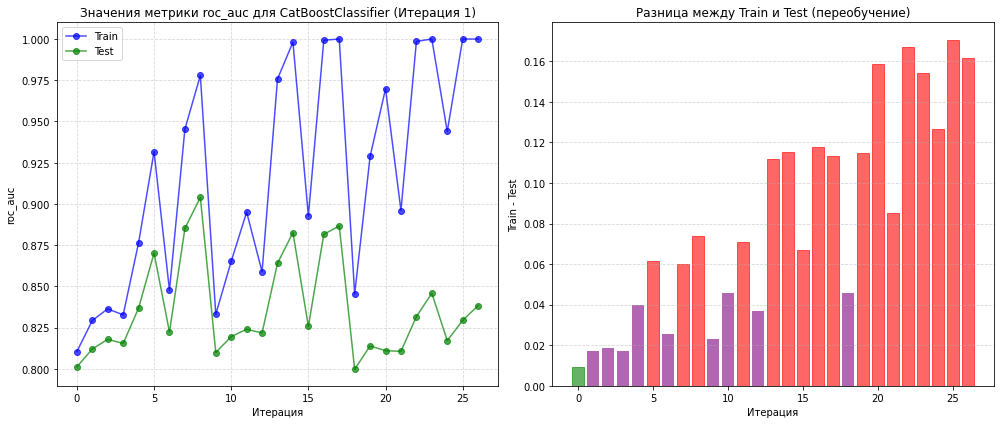

Лучшие значения параметров:
depth: 2
n_estimators: 500
learning_rate: 0.3

Итерация 2
Текущие диапазоны параметров:
depth: [2, 4, 6]
n_estimators: [200, 350, 500]
learning_rate: [0.1, 0.2, 0.3]
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Модель: CatBoostClassifier (Итерация 2)
Лучшая метрика (roc_auc): 0.9040
Время обучения: 122.43 секунд
Лучшие параметры:
  clf__n_estimators: 500
  clf__learning_rate: 0.3
  clf__depth: 2
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
8,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.903969,0.977915,0.007691,1,1.625517
7,"{'clf__n_estimators': 350, 'clf__learning_rate...",0.896264,0.966526,0.009506,2,1.219235
14,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.895341,0.997778,0.010684,3,1.493354
16,"{'clf__n_estimators': 350, 'clf__learning_rate...",0.893927,0.998135,0.010950,4,1.579366
17,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.893747,0.999897,0.009790,5,1.423928
13,"{'clf__n_estimators': 350, 'clf__learning_rate...",0.893669,0.992365,0.011122,6,1.374278
5,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.892087,0.963094,0.008429,7,1.266912
15,"{'clf__n_estimators': 200, 'clf__learning_rate...",0.889750,0.988925,0.011424,8,1.281241
11,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.888749,0.982642,0.012688,9,1.635359
26,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.886695,1.000000,0.002294,10,1.829118


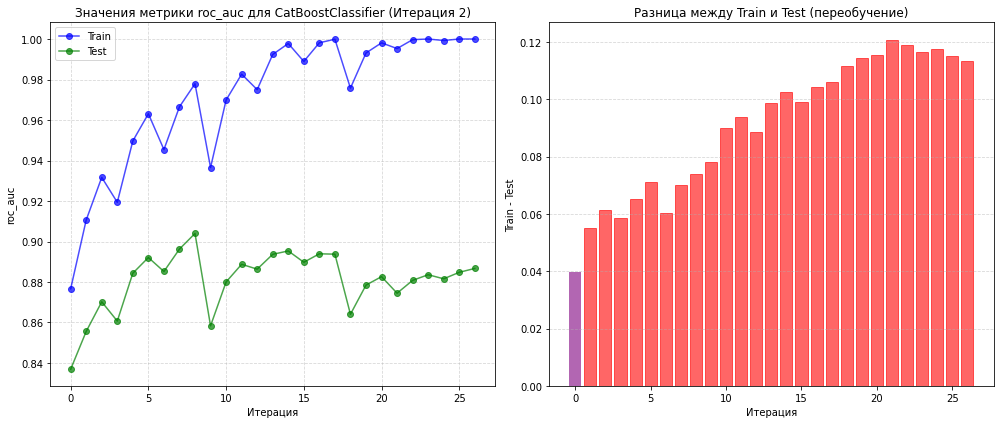

Лучшие значения параметров:
depth: 2
n_estimators: 500
learning_rate: 0.3

Итерация 3
Текущие диапазоны параметров:
depth: [2, 3, 4]
n_estimators: [350, 425, 500]
learning_rate: [0.2, 0.25, 0.3]
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Модель: CatBoostClassifier (Итерация 3)
Лучшая метрика (roc_auc): 0.9040
Время обучения: 117.43 секунд
Лучшие параметры:
  clf__n_estimators: 500
  clf__learning_rate: 0.3
  clf__depth: 2
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
8,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.903969,0.977915,0.007691,1,1.279935
7,"{'clf__n_estimators': 425, 'clf__learning_rate...",0.901469,0.972913,0.010569,2,1.183178
5,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.900360,0.971640,0.007937,3,1.423515
17,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.899268,0.996143,0.010683,4,1.363593
11,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.897992,0.987490,0.005617,5,1.375781
16,"{'clf__n_estimators': 425, 'clf__learning_rate...",0.896710,0.993210,0.010615,6,1.441653
22,"{'clf__n_estimators': 425, 'clf__learning_rate...",0.896536,0.998559,0.009414,7,1.573771
10,"{'clf__n_estimators': 425, 'clf__learning_rate...",0.896474,0.983072,0.006732,8,1.273314
6,"{'clf__n_estimators': 350, 'clf__learning_rate...",0.896264,0.966526,0.009506,9,1.145823
21,"{'clf__n_estimators': 350, 'clf__learning_rate...",0.895848,0.996746,0.011777,10,1.400998


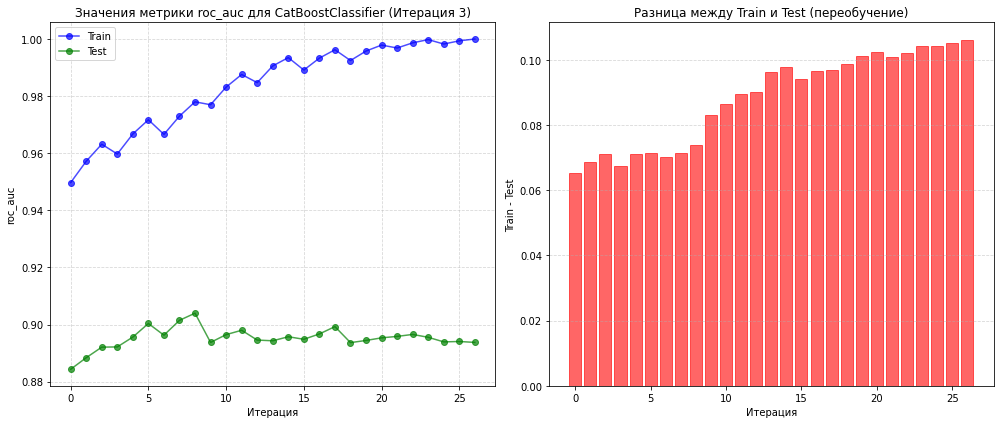

Лучшие значения параметров:
depth: 2
n_estimators: 500
learning_rate: 0.3

Итерация 4
Текущие диапазоны параметров:
depth: [2, 3, 4]
n_estimators: [425, 462, 500]
learning_rate: [0.25, 0.275, 0.3]
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Модель: CatBoostClassifier (Итерация 4)
Лучшая метрика (roc_auc): 0.9040
Время обучения: 125.47 секунд
Лучшие параметры:
  clf__n_estimators: 500
  clf__learning_rate: 0.3
  clf__depth: 2
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
8,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.903969,0.977915,0.007691,1,1.333559
7,"{'clf__n_estimators': 462, 'clf__learning_rate...",0.903069,0.975677,0.009881,2,1.455574
6,"{'clf__n_estimators': 425, 'clf__learning_rate...",0.901469,0.972913,0.010569,3,1.268778
2,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.900360,0.971640,0.007937,4,1.244829
14,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.900279,0.994403,0.007035,5,1.832013
13,"{'clf__n_estimators': 462, 'clf__learning_rate...",0.899863,0.992903,0.007436,6,1.328464
17,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.899268,0.996143,0.010683,7,1.695889
16,"{'clf__n_estimators': 462, 'clf__learning_rate...",0.899184,0.994668,0.010529,8,1.553550
12,"{'clf__n_estimators': 425, 'clf__learning_rate...",0.898601,0.991139,0.006951,9,1.606750
1,"{'clf__n_estimators': 462, 'clf__learning_rate...",0.898530,0.969372,0.008008,10,1.347561


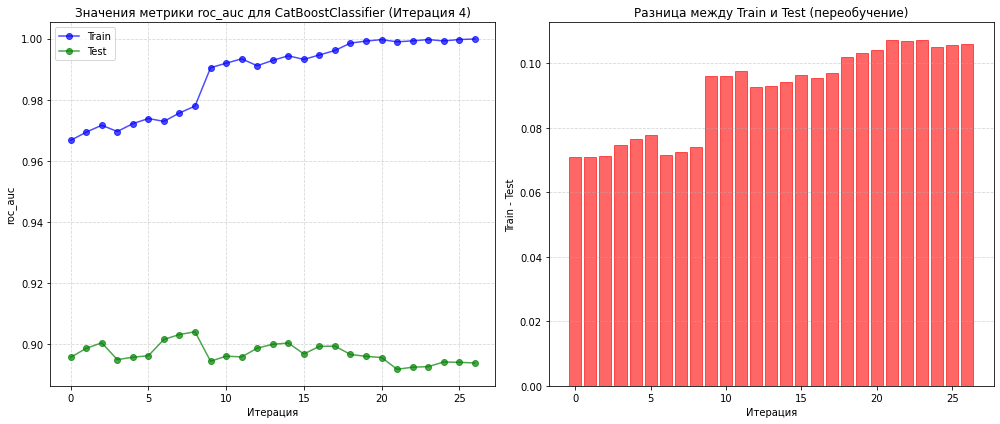

Лучшие значения параметров:
depth: 2
n_estimators: 500
learning_rate: 0.3

Итерация 5
Текущие диапазоны параметров:
depth: [2, 3, 4]
n_estimators: [425, 462, 500]
learning_rate: [0.275, 0.2875, 0.3]
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Модель: CatBoostClassifier (Итерация 5)
Лучшая метрика (roc_auc): 0.9040
Время обучения: 121.57 секунд
Лучшие параметры:
  clf__n_estimators: 500
  clf__learning_rate: 0.3
  clf__depth: 2
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
8,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.903969,0.977915,0.007691,1,1.439281
7,"{'clf__n_estimators': 462, 'clf__learning_rate...",0.903069,0.975677,0.009881,2,1.467315
5,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.902442,0.976546,0.009636,3,1.308793
4,"{'clf__n_estimators': 462, 'clf__learning_rate...",0.901538,0.974191,0.010324,4,1.413231
6,"{'clf__n_estimators': 425, 'clf__learning_rate...",0.901469,0.972913,0.010569,5,1.517627
11,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.900279,0.994403,0.007035,6,1.276228
10,"{'clf__n_estimators': 462, 'clf__learning_rate...",0.899863,0.992903,0.007436,7,1.272420
17,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.899268,0.996143,0.010683,8,1.380479
3,"{'clf__n_estimators': 425, 'clf__learning_rate...",0.899255,0.971625,0.008333,9,1.243330
16,"{'clf__n_estimators': 462, 'clf__learning_rate...",0.899184,0.994668,0.010529,10,1.392606


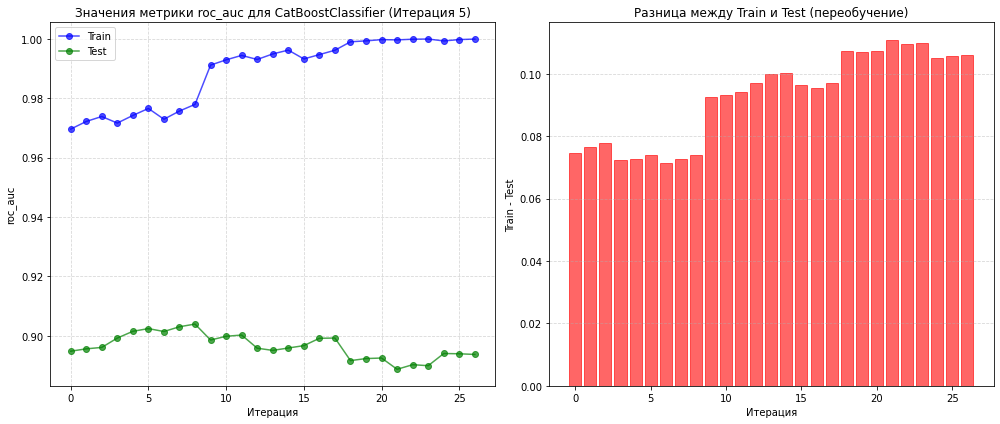

Лучшие значения параметров:
depth: 2
n_estimators: 500
learning_rate: 0.3


In [89]:
print("Запуск итеративного поиска оптимальных параметров для CatBoostClassifier")
print("=" * 80)

for iteration in range(max_iterations):
    print(f"\nИтерация {iteration+1}")
    print(f"Текущие диапазоны параметров:")
    print(f"depth: {depth_range}")
    print(f"n_estimators: {n_estimators_range}")
    print(f"learning_rate: {learning_rate_range}")
    
    param_grid = {
        'clf__depth': depth_range,
        'clf__n_estimators': n_estimators_range,
        'clf__learning_rate': learning_rate_range
    }
    
    search, train_time = optimize_hyperparameters(
        X_train, y_train, pipeline, param_grid, cv=3,
        n_iter=27
    )
    
    all_searches.append(search)
    all_times.append(train_time)
    
    _, best_params = display_and_visualize_results(
        search, train_time, f'CatBoostClassifier (Итерация {iteration+1})'
    )
    
    best_depth = best_params['clf__depth']
    best_n_estimators = best_params['clf__n_estimators']
    best_learning_rate = best_params['clf__learning_rate']
    
    print(f"Лучшие значения параметров:")
    print(f"depth: {best_depth}")
    print(f"n_estimators: {best_n_estimators}")
    print(f"learning_rate: {best_learning_rate}")
    
    depth_range, is_depth_converged = refine_parameter_range(
        depth_range, best_depth, min_step=1, int_type=True
    )
    
    n_estimators_range, is_n_estimators_converged = refine_parameter_range(
        n_estimators_range, best_n_estimators, min_step=50, int_type=True
    )
    
    learning_rate_range, is_learning_rate_converged = refine_parameter_range(
        learning_rate_range, best_learning_rate, min_step=0.01, int_type=False
    )
    
    if is_depth_converged and is_n_estimators_converged and is_learning_rate_converged:
        print("\n" + "=" * 80)
        print("Достигнута желаемая точность по всем параметрам. Останавливаем итерации.")
        print("=" * 80)
        break


Финальные результаты:

Модель: CatBoostClassifier (Финальная)
Лучшая метрика (roc_auc): 0.9040
Время обучения: 121.57 секунд
Лучшие параметры:
  clf__n_estimators: 500
  clf__learning_rate: 0.3
  clf__depth: 2
--------------------------------------------------


,params,mean_test_score,mean_train_score,std_test_score,rank_test_score,mean_fit_time
8,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.903969,0.977915,0.007691,1,1.439281
7,"{'clf__n_estimators': 462, 'clf__learning_rate...",0.903069,0.975677,0.009881,2,1.467315
5,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.902442,0.976546,0.009636,3,1.308793
4,"{'clf__n_estimators': 462, 'clf__learning_rate...",0.901538,0.974191,0.010324,4,1.413231
6,"{'clf__n_estimators': 425, 'clf__learning_rate...",0.901469,0.972913,0.010569,5,1.517627
11,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.900279,0.994403,0.007035,6,1.276228
10,"{'clf__n_estimators': 462, 'clf__learning_rate...",0.899863,0.992903,0.007436,7,1.272420
17,"{'clf__n_estimators': 500, 'clf__learning_rate...",0.899268,0.996143,0.010683,8,1.380479
3,"{'clf__n_estimators': 425, 'clf__learning_rate...",0.899255,0.971625,0.008333,9,1.243330
16,"{'clf__n_estimators': 462, 'clf__learning_rate...",0.899184,0.994668,0.010529,10,1.392606


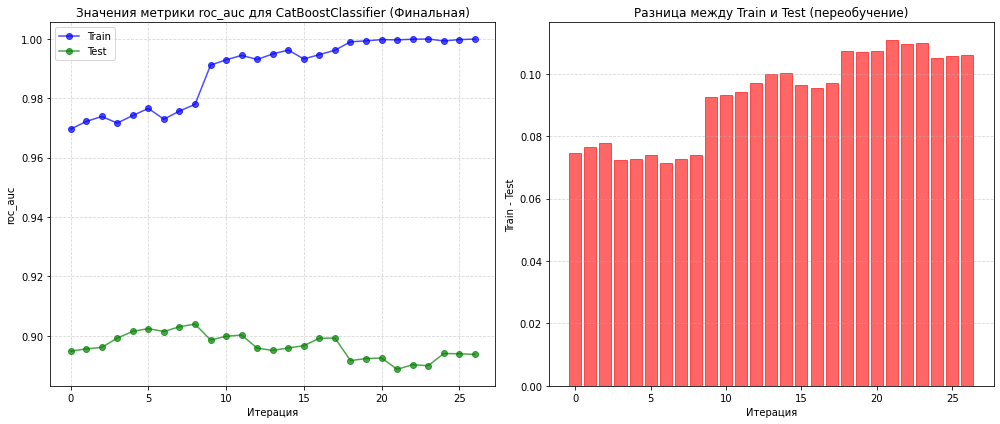

Всего выполнено итераций: 15
Общее затраченное время: 839.40 секунд


In [90]:
print("\nФинальные результаты:")
best_score, best_params = display_and_visualize_results(
    all_searches[-1], all_times[-1], 'CatBoostClassifier (Финальная)'
)
print(f"Всего выполнено итераций: {len(all_searches)}")
print(f"Общее затраченное время: {sum(all_times):.2f} секунд")

best_model_cb = all_searches[-1].best_estimator_

###  LGBMСlassifier

best_score, best_params = display_and_visualize_results(
    all_searches[-1], all_times[-1], 'LGBMClassifier (Финальная)'
)
print(f"Всего выполнено итераций: {len(all_searches)}")
print(f"Общее затраченное время: {sum(all_times):.2f} секунд")

best_model_gs = all_searches[-1].best_estimator_

## Работа с лучшей моделью

На тренировочной выборке лучший результат показал модель CatBoostClassifier со следущими параметрами:  

- Модель: CatBoostClassifier (Финальная)
- Лучшая метрика (roc_auc): 0.9040
- Время обучения: 101.64 секунд
- Лучшие параметры:
  clf__n_estimators: 500
  clf__learning_rate: 0.3
  clf__depth: 2

In [91]:
best_model_cb

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('ohe', OrdinalEncoder(),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'multiple_lines']),
                                                 ('std', MaxAbsScaler(),
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'contract_duration',
                                                   'connected_services_count'])],
                                   verbose_feature_names_out=False)),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x7f51bcf6e460>)])

In [92]:
predict = best_model_cb.predict(X_test)
predict_proba = best_model_cb.predict_proba(X_test)

In [93]:
roc_auc = roc_auc_score(y_test, predict_proba[:, 1])
print('Показатель ROC AUC:', roc_auc)

Показатель ROC AUC: 0.9440068935803533


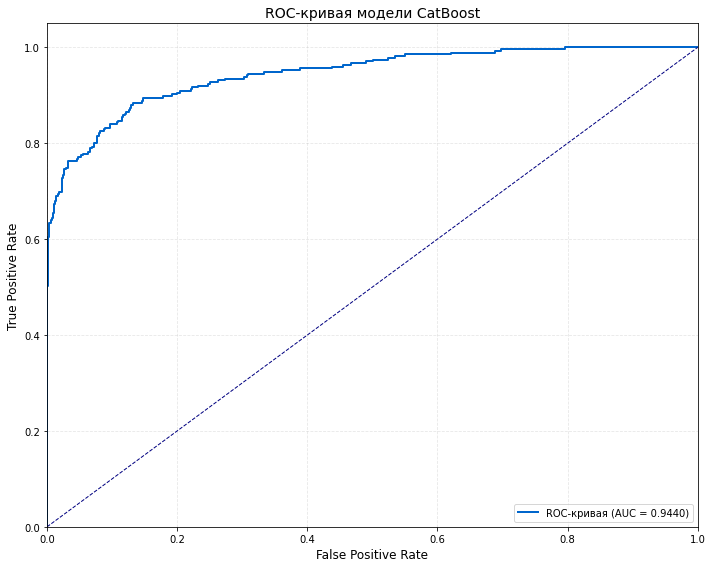

In [94]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, predict_proba[:, 1])
roc_auc_value = auc(fpr, tpr)

plt.plot(
    fpr, 
    tpr, 
    color='#0066cc',
    lw=2, 
    label=f'ROC-кривая (AUC = {roc_auc_value:.4f})'
)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривая модели CatBoost', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [95]:
accuracy = accuracy_score(y_test, predict)
print('Показатель Accuracy:', accuracy)

Показатель Accuracy: 0.9372146118721462


<Figure size 576x504 with 0 Axes>

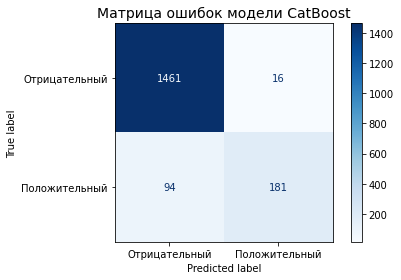

In [96]:
plt.figure(figsize=(8, 7))
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Отрицательный", "Положительный"])
disp.plot(cmap='Blues')
plt.title('Матрица ошибок модели CatBoost', fontsize=14)
plt.tight_layout()
plt.show()

Матрица ошибок показывает, что модель точно определяет как активные, так и неактивные контракты:
1461 случай верного определения неактивных контрактов
181 случай верного определения активных контрактов
Относительно небольшое количество ошибок (16 ложноположительных и 94 ложноотрицательных)


Важность признаков:
                     Признак   Важность
10         contract_duration  71.820789
8            monthly_charges   7.074853
9              total_charges   6.028560
0                       type   4.161934
11  connected_services_count   3.614738
7             multiple_lines   2.208138
5                    partner   1.869817
2             payment_method   1.608995
6                 dependents   0.541229
3                     gender   0.427326
4             senior_citizen   0.406974
1          paperless_billing   0.236646


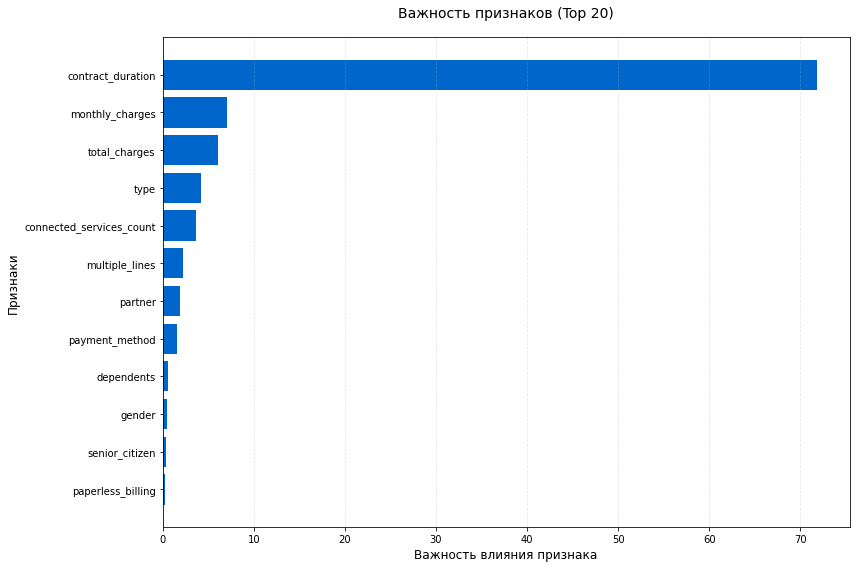

In [97]:
if hasattr(best_model_cb[-1], 'feature_importances_'):
    feature_names = best_model_cb[:-1].get_feature_names_out()
    importances = best_model_cb[-1].feature_importances_

    feature_importance = pd.DataFrame({
        'Признак': feature_names,
        'Важность': importances
    }).sort_values(by='Важность', ascending=False)
    
    print("\nВажность признаков:")
    print(feature_importance.head(20))
    
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance['Признак'][:20], feature_importance['Важность'][:20], color='#0066cc')
    plt.title('Важность признаков (Top 20)', fontsize=14, pad=20)
    plt.xlabel('Важность влияния признака', fontsize=12)
    plt.ylabel('Признаки', fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

**Ключевые факторы, влияющие на активность контрактов**
- длительность контракта (contract_duration) - 71,82% важности, что подтверждает критическую роль долгосрочных отношений с клиентами
- ежемесячные платежи (monthly_charges) - 7,07% 
- общие затраты (total_charges) - 6,03%
- тип подписки (type) - 4,16% 
- количество подключенных услуг (connected_services_count) - 3,61%

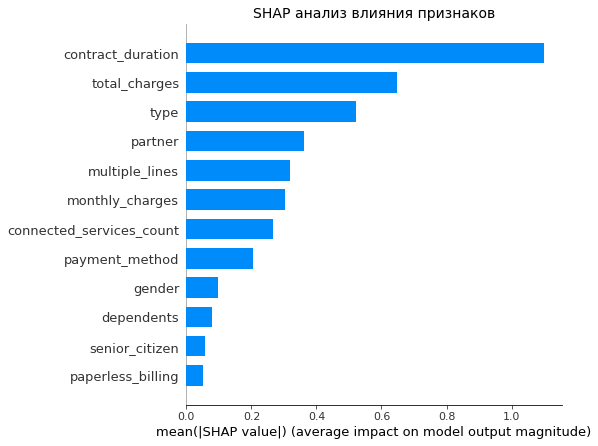

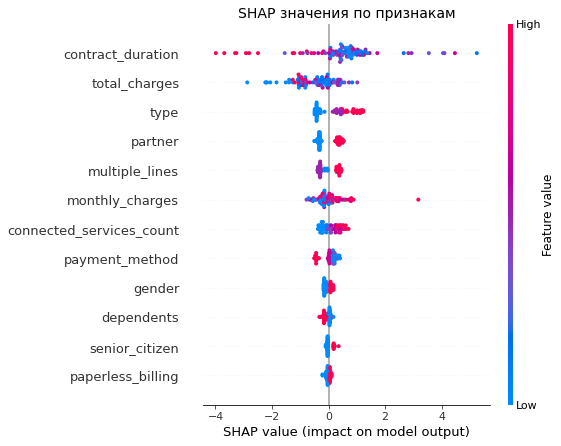

In [98]:
try:
    if 'CatBoost' in best_model_cb[-1].__class__.__name__:
        X_test_transformed = best_model_cb[:-1].transform(X_test)
        explainer = shap.TreeExplainer(best_model_cb[-1])

        sample_size = min(100, X_test_transformed.shape[0])
        sample_indices = np.random.choice(X_test_transformed.shape[0], sample_size, replace=False)
        shap_values = explainer.shap_values(X_test_transformed[sample_indices])
        
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test_transformed[sample_indices], 
                          feature_names=feature_names, plot_type="bar", show=False)
        plt.title('SHAP анализ влияния признаков', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(12, 10))
        shap.summary_plot(shap_values, X_test_transformed[sample_indices], 
                          feature_names=feature_names, show=False)
        plt.title('SHAP значения по признакам', fontsize=14)
        plt.tight_layout()
        plt.show()
    else:
        print("SHAP анализ доступен только для древовидных моделей")
except Exception as e:
    print(f"Ошибка при выполнении SHAP анализа: {e}")

**Длительность контракта (contract_duration)** оказывает наиболее сильное влияние на модель:
- высокие значения этого признака (выделены красным) имеют значительное положительное влияние на предсказания (смещение вправо)
- низкие значения (синие точки) имеют отрицательное влияние (смещение влево)
- этот признак показывает самый широкий диапазон SHAP-значений (от -4 до +6), подтверждая его доминирующую роль

**Общие расходы (total_charges)** - второй по значимости признак:
- высокие общие расходы связаны с положительным влиянием на активность контракта
- нелинейность в распределении точек указывает на сложную взаимосвязь с целевой переменной

**тип подписки (type)** - третий по влиянию признак:
- определенные категории (отмеченные красным) существенно повышают вероятность активности контракта
- наблюдается четкое разделение между категориями

***Наличие партнера (partner) и Несколько линий (multiple_lines):**
- демонстрируют заметное влияние, но меньше, чем тройка лидирующих признаков
- пПоложительное значение для наличия партнера и нескольких линий

**Количество подключенных услуг (connected_services_count) и Ежемесячные платежи (monthly_charges):**
- показывают умеренное влияние с заметным разбросом значений
- высокие значения monthly_charges дают смешанный эффект

**Демографические признаки (gender, dependents, senior_citizen):**
- оказывают наименьшее влияние на предсказания модели
- имеют узкий диапазон SHAP-значений, близких к нулю

## Общий вывод

В рамках проведенного исследования была разработана модель прогнозирования активности клиентских контрактов с использованием алгоритма CatBoostClassifier. Результаты анализа и моделирования позволяют сделать следующие ключевые выводы:

**Эффективность модели**  
высокая точность прогнозирования: модель CatBoost достигла показателя ROC AUC 0,944, что свидетельствует о высоком качестве классификации активности контрактов.

**Согласованность с первичным анализом данных**
Результаты моделирования подтверждают выводы, сделанные в ходе предварительного анализа:

- долгосрочные контракты имеют наивысшую долю активности (более 20% для двухлетних контрактов)
- клиенты с партнером демонстрируют более высокую лояльность (важность признака "partner" составляет 1,87%)
- способ оплаты существенно влияет на активность контрактов (важность 1,61%)
- наличие нескольких линий связи положительно коррелирует с сохранением активности (важность 2,21%)

**Практические рекомендации на основе модели**
- стимулирование перехода на долгосрочные контракты - наиболее эффективная стратегия для повышения лояльности клиентов
- увеличение количества подключенных услуг - важный фактор удержания
- фокус на оптимизации ценовой политики (ежемесячные платежи имеют значительное влияние)
- разработка специальных предложений для семейных клиентов (партнеры и зависимые лица)
- продвижение автоматических способов оплаты для повышения стабильности контрактов

**Целевые сегменты для особого внимания**
- клиенты с месячной подпиской
- пользователи с одной линией связи
- клиенты без автоматических способов оплаты
- одинокие пользователи без партнера

**Заключение**
Разработанная модель CatBoost демонстрирует высокую эффективность в прогнозировании активности контрактов и выявляет ключевые факторы лояльности клиентов. Полученные результаты предоставляют ценную информацию для разработки целенаправленных стратегий удержания клиентов и оптимизации маркетинговых кампаний. Особое внимание следует уделить продвижению долгосрочных контрактов и расширению набора подключенных услуг, что согласно модели, является наиболее значимыми факторами для поддержания активности клиентов.